In [ ]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)

In [ ]:
tf.enable_eager_execution()

# Introduction

<p>Following Marin, Pudlo, & Etroup (2019), we will construct a toy model selection example consisting of three unidimensional models with tractable marginal likelihoods.</p>

1. Model 1 is an exponential distribution with rate parameter  $\lambda$
2. Model 2 is a log-normal distribution with location parameter $\mu$ and fixed scale parameter $\sigma = 1$
3. Model 3 is a gamma distribution with parameters $\alpha = 2$ (shape) and $\beta$ (rate)
<p>To do - marginal likelihoods</p>

# Model definitions

In [47]:
class InvariantModule(tf.keras.Model):
    """Implements an invariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, h_dim, n_dense=3):
        """
        Creates an invariant function with mean pooling.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(InvariantModule, self).__init__()
        
        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(h_dim, activation='elu', kernel_initializer='glorot_uniform') 
            for _ in range(n_dense)
        ])

        self.post_pooling_dense = tf.keras.layers.Dense(h_dim, activation='elu', kernel_initializer='glorot_uniform')   
        
    def call(self, x):
        """
        Transofrms the input into an invariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.module(x)
        x = tf.reduce_mean(x, axis=1)
        out = self.post_pooling_dense(x)
        return out
    

class EquivariantModule(tf.keras.Model):
    """Implements an equivariant nn module as proposed by Bloem-Reddy and Teh (2019)."""

    def __init__(self, h_dim, n_dense=3):
        """
        Creates an equivariant neural network consisting of a FC network with
        equal number of hidden units in each layer and an invariant module
        with the same FC structure.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        """
        
        super(EquivariantModule, self).__init__()
        
        self.module = tf.keras.Sequential([
            tf.keras.layers.Dense(h_dim, activation='elu') 
            for _ in range(n_dense)
        ])
        
        self.invariant_module = InvariantModule(h_dim, n_dense)
        
    def call(self, x):
        """
        Transofrms the input into an equivariant representation.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 'samples' dimensions 
            over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x_inv = self.invariant_module(x)
        x_inv = tf.stack([x_inv] * int(x.shape[1]), axis=1) # Repeat x_inv n times
        x = tf.concat((x_inv, x), axis=-1)
        out = self.module(x)
        return out
    

class InvariantNetwork(tf.keras.Model):
    """
    Implements a network which parameterizes a 
    permutationally invariant function according to Bloem-Reddy and Teh (2019).
    """

    def __init__(self, h_dim, n_dense=3, n_equiv=2):
        """
        Creates a permutationally invariant network 
        consisting of two equivariant modules and one invariant module.
        ----------

        Arguments:
        h_dim   : int -- the number of hidden units in each of the modules
        n_dense : int -- the number of dense layers of the modules
        n_equiv : int -- the number of equivariant modules 
        """
        
        super(InvariantNetwork, self).__init__()
        
        self.equiv = tf.keras.Sequential([
            EquivariantModule(h_dim, n_dense)
            for _ in range(n_equiv)
        ])
        self.inv = InvariantModule(h_dim, n_dense)
        
    def call(self, x, **kwargs):
        """
        Transofrms the input into a permutationally invariant 
        representation by first passing it through multiple equivariant 
        modules in order to increase representational power.
        ----------

        Arguments:
        x : tf.Tensor of shape (batch_size, n, m) - the input where n is the 'time' or 
        'samples' dimensions over which pooling is performed and m is the input dimensionality
        ----------

        Returns:
        out : tf.Tensor of shape (batch_size, h_dim) -- the pooled and invariant representation of the input
        """

        x = self.equiv(x)
        out = self.inv(x)
        return out

    
class ModelSelector(tf.keras.Model):
    
    def __init__(self, k=3, inv_h_dim=32, n_equiv=2, z_dim=2, n_dense=2, summary_dim=128):
        super(ModelSelector, self).__init__()
        
        self.encoder = InvariantNetwork(inv_h_dim, n_equiv)
        self.z_mapper = tf.keras.Sequential([
            tf.keras.layers.Dense(summary_dim, activation='elu', kernel_initializer='glorot_uniform') 
            for _ in range(n_dense)
        ] +
        [tf.keras.layers.Dense(z_dim * 2, kernel_initializer='glorot_uniform') ]) 
        self.classifier = tf.keras.layers.Dense(k, kernel_initializer='glorot_uniform')
        
    def call(self, x, return_prob=False):
        """Encodes x into z, samples and decodes."""
        
        # Encode
        x = self.encoder(x)
        
        # Get z
        x = self.z_mapper(x)
        z_mean, z_logvar = tf.split(x, 2, axis=-1)
        
        # Sample
        eps = tf.random_normal(shape=z_mean.shape)
        z = z_mean + eps * tf.exp(z_logvar * 0.5)
        
        # Decode (returns model index)
        m_hat = self.classifier(z)
        if return_prob:
            m_hat = tf.nn.softmax(m_hat, axis=1)
        return z_mean, z_logvar, m_hat
    
    def sample(self, x, n_samples):
        """Samples model probabilities given data."""
        
        x = self.encoder(x)
        x = self.z_mapper(x)
        z_mean, z_logvar = tf.split(x, 2, axis=-1)
        eps = tf.random_normal(shape=(n_samples, z_mean.shape[0], z_mean.shape[1]))
        z = z_mean + eps * tf.exp(z_logvar * 0.5)
        z = tf.transpose(z, [1, 0, 2])
        m_probs = tf.nn.softmax(self.classifier(z), axis=-1)
        return m_probs        

# Utility functions

## Losses

In [5]:
def kl_loss(z_mean, z_logvar):
    """Computes the KL divergence between a unit Gaussian and an arbitrary Gaussian."""
    
    loss = 1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar)
    loss = -0.5 * tf.reduce_sum(loss, axis=-1)
    return tf.reduce_mean(loss)

def cross_entropy(m_true, logits):
    """Computes the softmax cross-entropy loss."""
    
    loss = tf.losses.softmax_cross_entropy(onehot_labels=m_true, logits=logits)
    return tf.reduce_mean(loss)

## Data generator

In [6]:
def generate_data(batch_size, n_points, to_tensor=True):
    
    
    # Make sure a model is nor oversampled
    batch_size_m = batch_size // 3
    batch_sizes = [batch_size_m, batch_size_m, batch_size_m]
    rest_m = batch_size % 3
    bi = np.argmax(np.random.rand(3))
    batch_sizes[bi] += rest_m
    
    # Draw from priors
    exp_scales = 1. / np.random.exponential(scale=1., size=batch_sizes[0])
    logn_means = np.random.normal(loc=0., scale=1., size=batch_sizes[1])
    gamma_scales = 1. /np.random.exponential(scale=1., size=batch_sizes[2])

    # Sample models
    exp_samples = np.random.exponential(scale=exp_scales, size=(n_points, batch_sizes[0])).T
    logn_samples = np.random.lognormal(mean=logn_means, sigma=1., size=(n_points, batch_sizes[1])).T
    gamma_samples = np.random.gamma(shape=2., scale=gamma_scales, size=(n_points, batch_sizes[2])).T
    
    # Stack data
    X_batch = np.r_[exp_samples, logn_samples, gamma_samples]
    m_batch = np.concatenate((np.zeros(batch_sizes[0]), 
                              np.ones(batch_sizes[1]), 
                              np.ones(batch_sizes[2]) + 1)).astype(np.int32)
    
    # Shuffle indices
    shuffle_idx = np.random.permutation(batch_size)
    X_batch = X_batch[shuffle_idx][:, :, np.newaxis]
    m_batch = m_batch[shuffle_idx]
    
    # Convert to one-hot
    m_batch_oh = np.zeros((batch_size, 3))
    m_batch_oh[np.arange(batch_size), m_batch] = 1
    
    if to_tensor:
        X_batch = tf.convert_to_tensor(X_batch, dtype=tf.float32)
        m_batch_oh = tf.convert_to_tensor(m_batch_oh, dtype=tf.float32)
    return X_batch, m_batch_oh

## Epoch loop

In [7]:
def train_loop_online(model, optimizer, data_generator, iterations, batch_size, 
                 X_test, m_test, p_bar, beta, transform=None, max_beta=0.2,
                 global_step=None, beta_update_every=1000, beta_increment=0.01, clip_value=5.):
    """
    Utility function to perform the # number of training loops given by the itertations argument.
    ---------

    Arguments:
    model           : tf.keras.Model -- the invertible chaoin with an optional summary net
                                        both models are jointly trained
    optimizer       : tf.train.optimizers.Optimizer -- the optimizer used for backprop
    data_generator  : callable -- a function providing batches of X, theta (data, params)
    iterations      : int -- the number of training loops to perform
    batch_size      : int -- the batch_size used for training
    p_bar           : ProgressBar -- an instance for tracking the training progress
    clip_value      : float       -- the value used for clipping the gradients
    global_step     : tf.EagerVariavle -- a scalar tensor tracking the number of 
                                            steps and used for learning rate decay  
    transform       : callable ot None -- a function to transform X and theta, if given
    n_smooth        : int -- a value indicating how many values to use for computing the running ML loss
    ----------

    Returns:
    losses : dict -- a dictionary with the ml_loss and decay
    """
    
    for it in range(iterations):

        X_batch, m_batch = data_generator(batch_size)

        with tf.GradientTape() as tape:

            # Forward pass
            z_mean, z_logvar, m_hat = model(X_batch)

            # Compute losses
            kl = beta * kl_loss(z_mean, z_logvar)
            rec = cross_entropy(m_batch, m_hat)
            total_loss = kl + rec
        
        # Compute accuracies
        m_hat_train = tf.math.argmax(tf.nn.softmax(m_hat, axis=1), axis=1).numpy()
        _, _, m_hat_test = model(X_test, return_prob=True)
        m_hat_test = tf.math.argmax(m_hat_test, axis=1).numpy()
        train_acc = np.sum(m_hat_train == tf.math.argmax(m_batch, axis=1).numpy()) / m_hat_train.shape[0]
        test_acc = np.sum(m_hat_test == tf.math.argmax(m_test, axis=1).numpy()) / m_hat_test.shape[0]

        # One step backprop
        gradients = tape.gradient(total_loss, model.trainable_variables)
        if clip_value is not None:
            try:
                gradients, _ = tf.clip_by_global_norm(gradients, clip_value)
            except tf.errors.InvalidArgumentError as e:
                print(str(e))
                gradients = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients]
        optimizer.apply_gradients(zip(gradients, model.trainable_variables), global_step=global_step)
        
        # Increase beta every 500 iterations
        if (global_step.numpy() + 1) % beta_update_every == 0:
            tf.assign(beta, min(max_beta, beta.numpy() + beta_increment))

        # Update p-bar
        p_bar.set_postfix_str("It: {0}, Loss:{1:.3f},Rec:{2:.3f},KL.:{3:.3f},Train Acc.:{4:.3f},Test Acc.:{5:.3f}".format(
        it, total_loss.numpy(), rec.numpy(), kl.numpy(), train_acc, test_acc))
        p_bar.update(1)

## Plot latent dim

In [22]:
def plot_latent(z_mean, m_test, figsize=(8, 6)):
    f, ax = plt.subplots(1, 1, figsize=figsize)
    ax.scatter(z_mean[:, 0], z_mean[:, 1], c=m_test)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axvline(0, color='black')
    ax.axhline(0, color='black')
    plt.show()

## Plot distributions

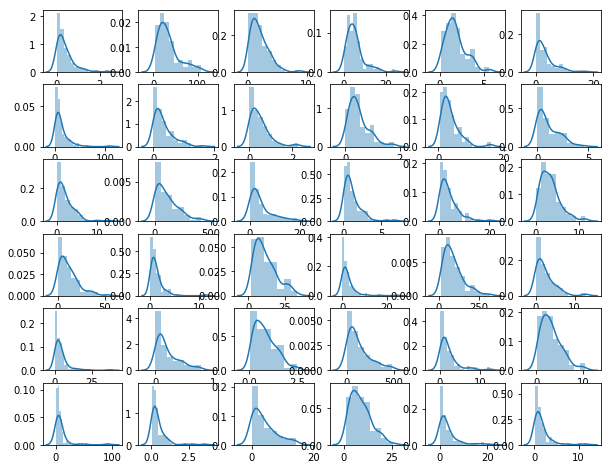

In [8]:
X, _ = generate_data(36, 100, to_tensor=False)

f, axarr = plt.subplots(6, 6, figsize=(10, 8))

for i in range(36):
    sns.distplot(X[i], ax=axarr.flat[i])

# Training parameters

In [9]:
nn_params = dict(k=3, inv_h_dim=32, summary_dim=32,n_dense=2, z_dim=2, n_equiv=2)
n_post_samples = 1000
n_points = 200
n_test = 300
epochs = 100
batch_size = 64
learning_rate = 0.0005
iterations_per_epoch = 100
clip_value = 5.
global_step = tfe.Variable(0, dtype=tf.int32)
beta = tfe.Variable(0.0, dtype=tf.float32)
data_gen = partial(generate_data, n_points=n_points)

## Create test

In [19]:
X_test, m_test = data_gen(n_test)

## Create model and optimizer

In [48]:
model = ModelSelector(**nn_params)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

## Plot untrained

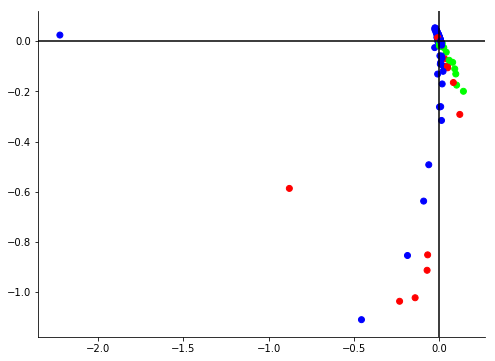

In [23]:
z_mean, _, _ = model(X_test, return_prob=True)
plot_latent(z_mean, m_test)

## Manage checkpoints

In [49]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/toy2', max_to_keep=5)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/toy2\ckpt-228


## Run training loop

Value of beta:  0.0
Instructions for updating:
Use tf.cast instead.


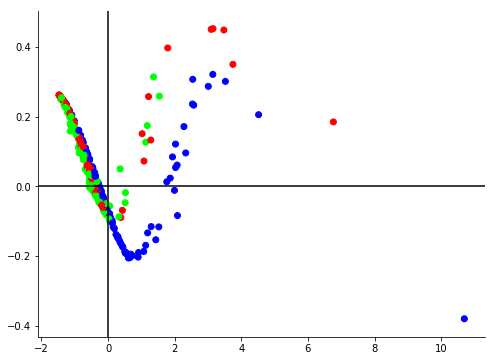

Value of beta:  0.0


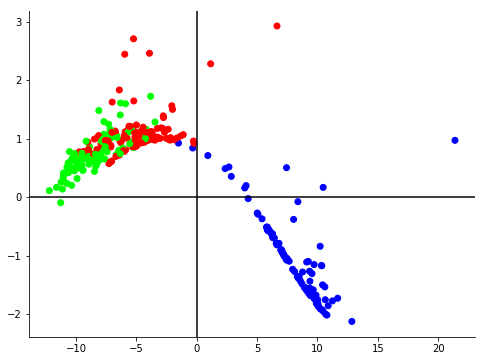

Value of beta:  0.0


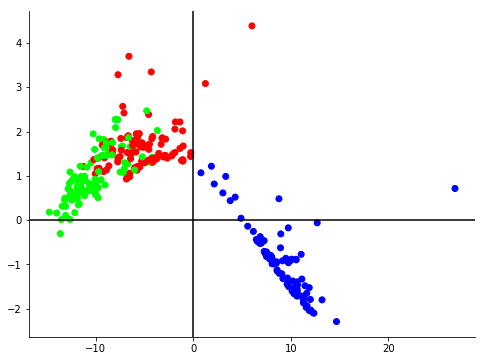

Value of beta:  0.0


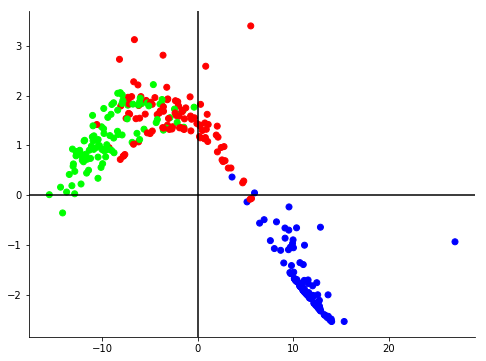

Value of beta:  0.0


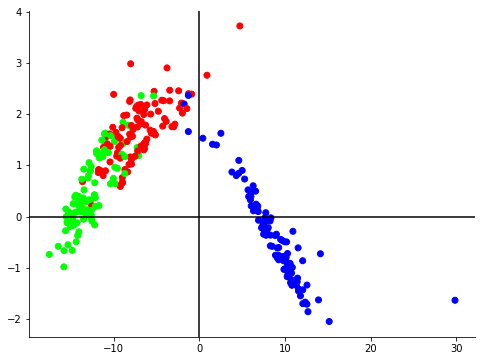

Value of beta:  0.0


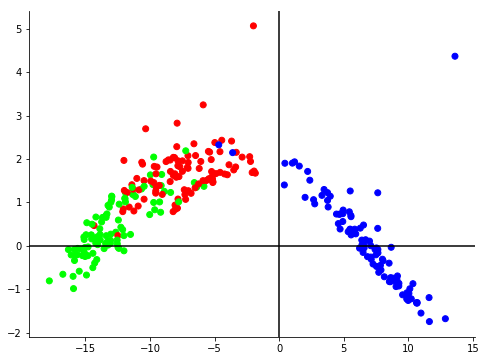

Instructions for updating:
Use standard file APIs to delete files with this prefix.



Value of beta:  0.0


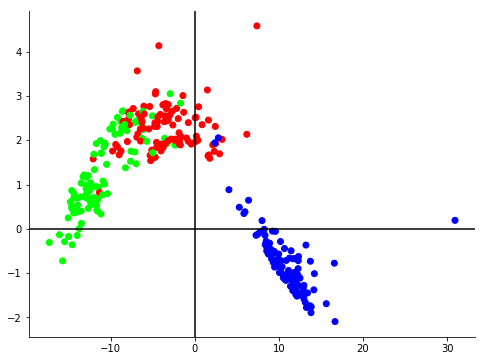

Value of beta:  0.0


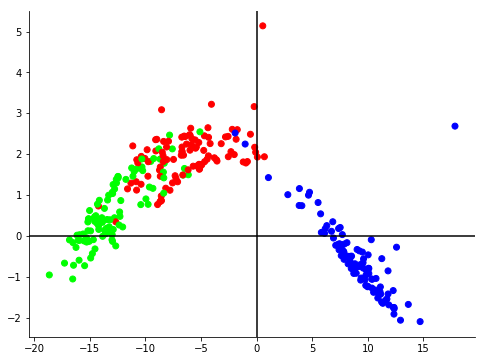

Value of beta:  0.0


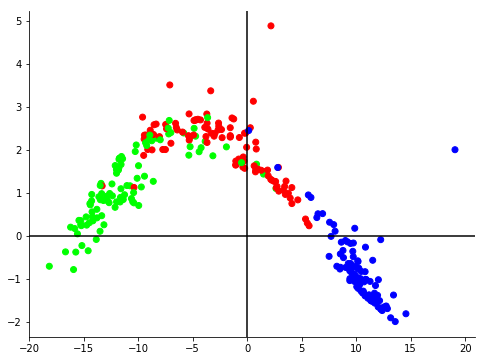

Value of beta:  0.0


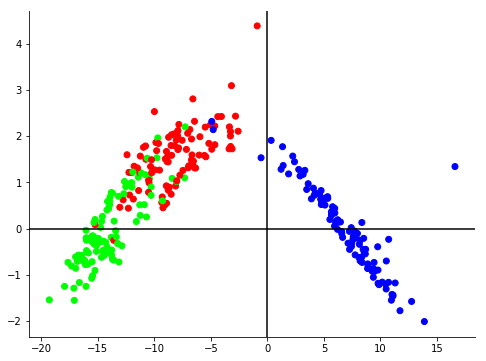

Value of beta:  0.01


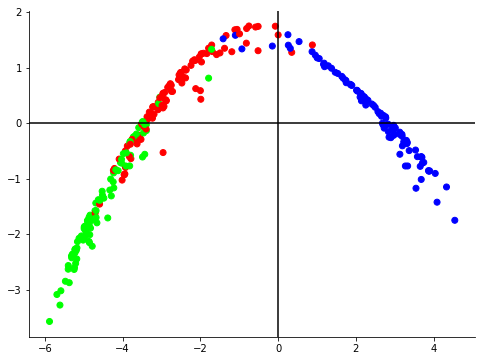

Value of beta:  0.01


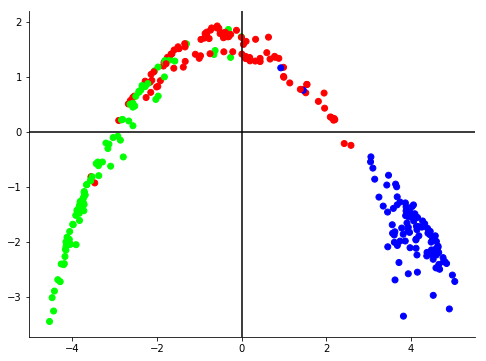

Value of beta:  0.01


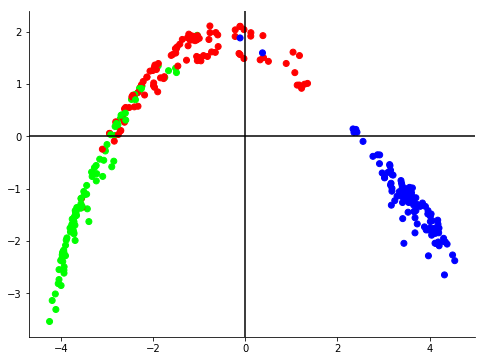

Value of beta:  0.01


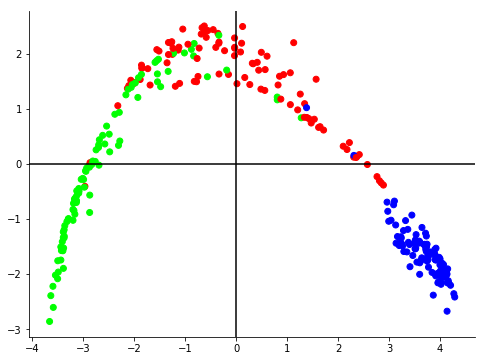

Value of beta:  0.01


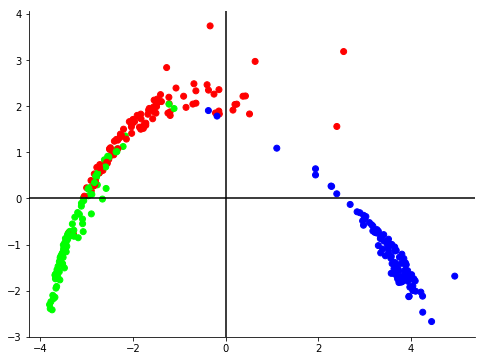

Value of beta:  0.01


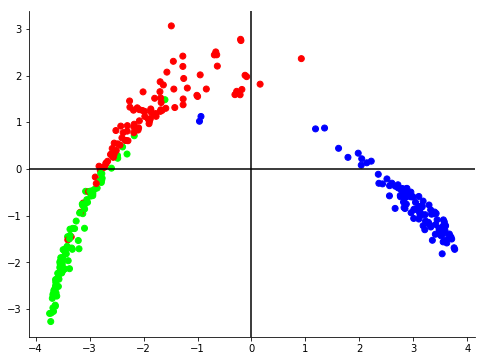

Value of beta:  0.01


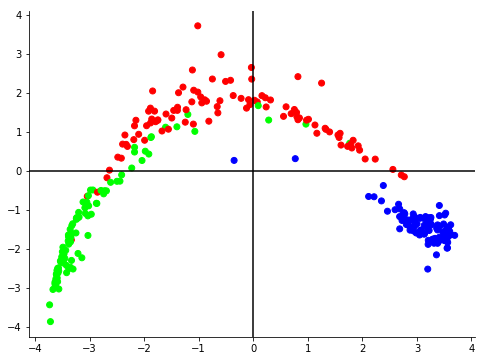

Value of beta:  0.01


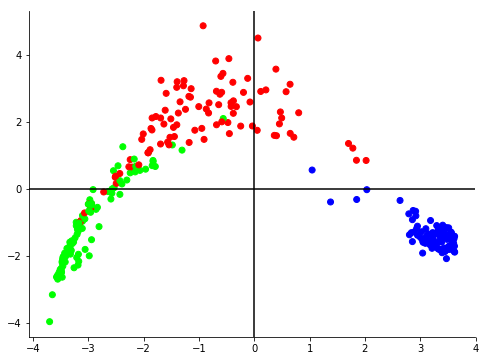

Value of beta:  0.01


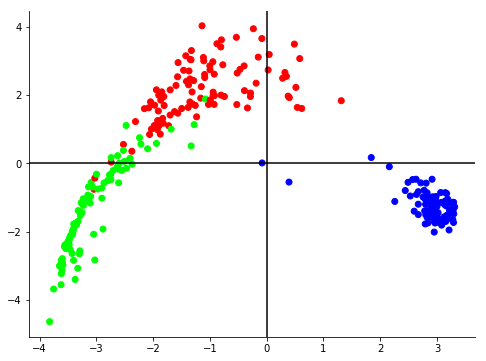

Value of beta:  0.01


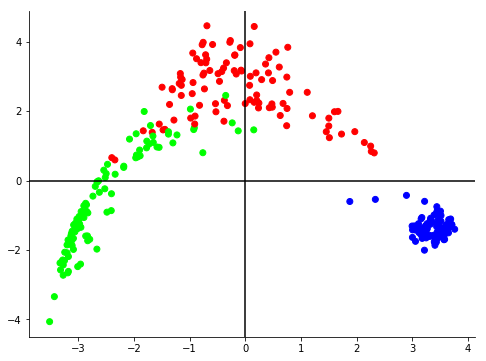

Value of beta:  0.02


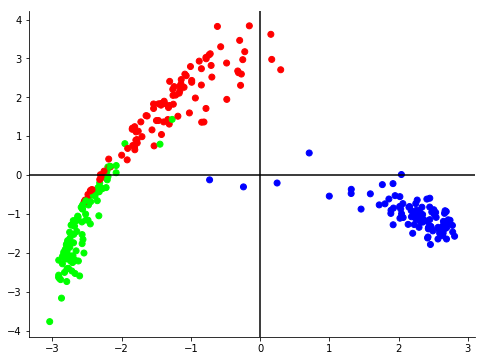

Value of beta:  0.02


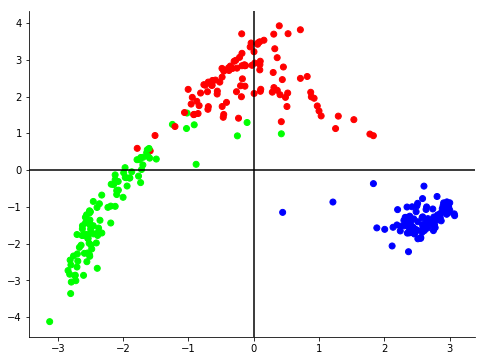

Value of beta:  0.02


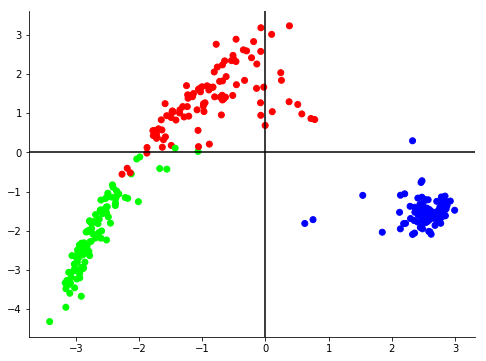

Value of beta:  0.02


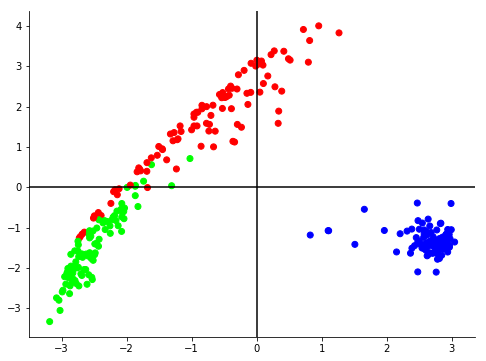

Value of beta:  0.02


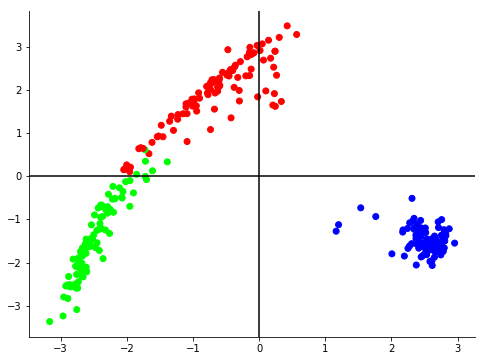

Value of beta:  0.02


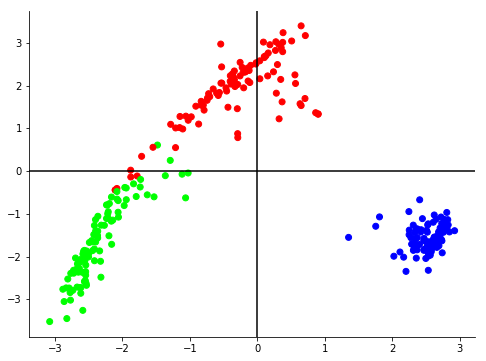

Value of beta:  0.02


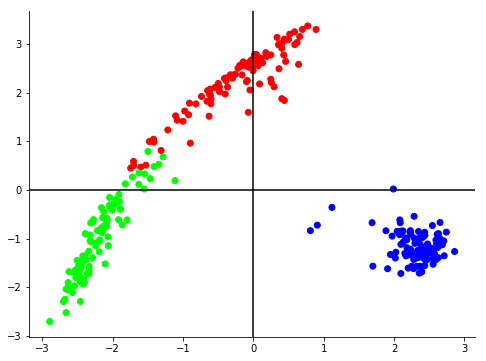

Value of beta:  0.02


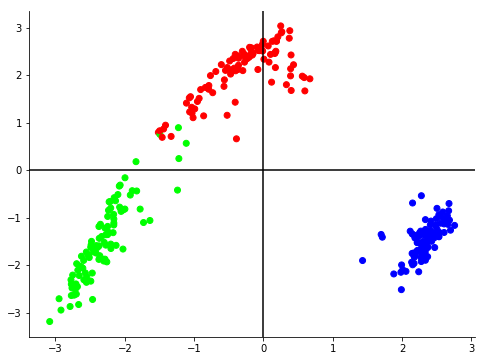

Value of beta:  0.02


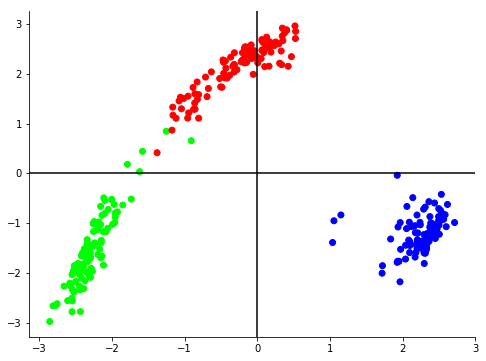

Value of beta:  0.02


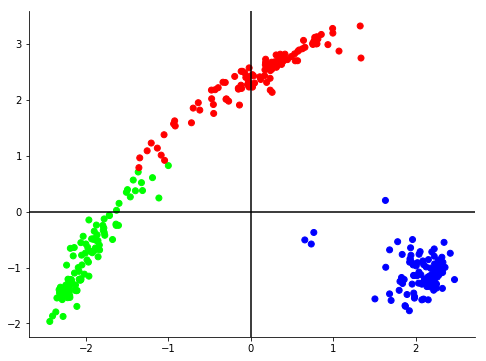

Value of beta:  0.03


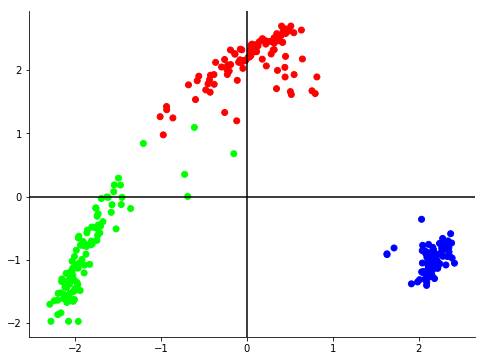

Value of beta:  0.03


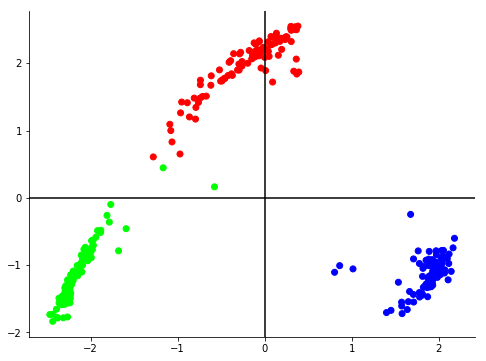

Value of beta:  0.03


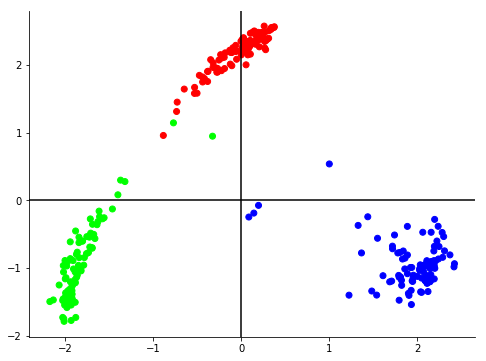

Value of beta:  0.03


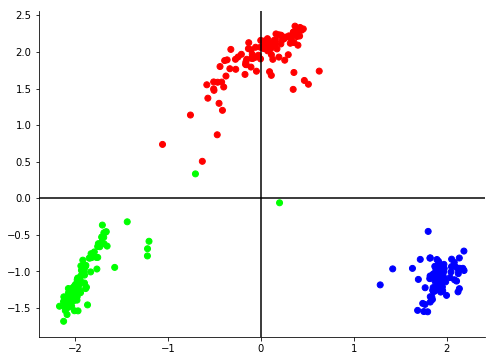

Value of beta:  0.03


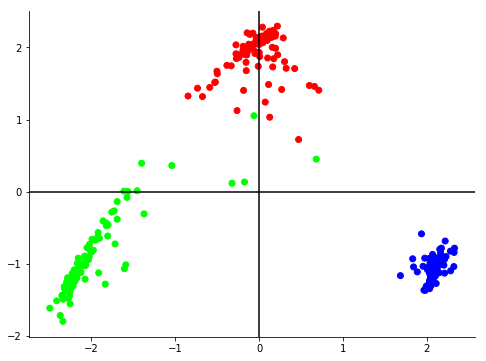

Value of beta:  0.03


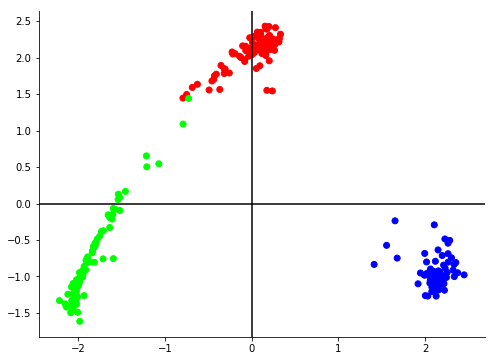

Value of beta:  0.03


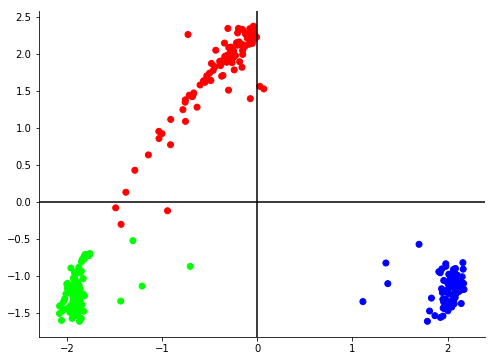

Value of beta:  0.03


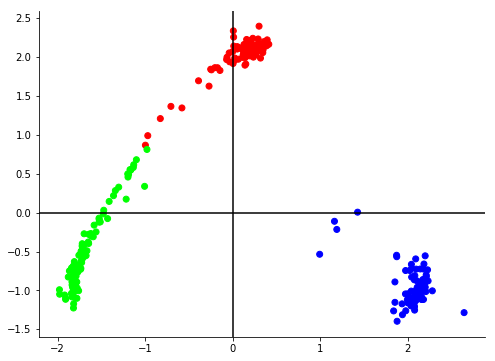

Value of beta:  0.03


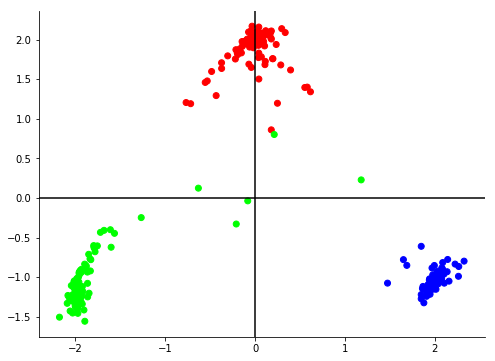

Value of beta:  0.03


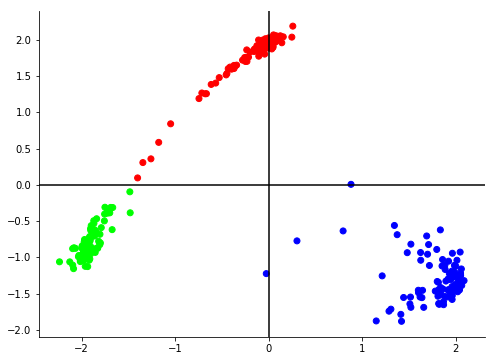

Value of beta:  0.04


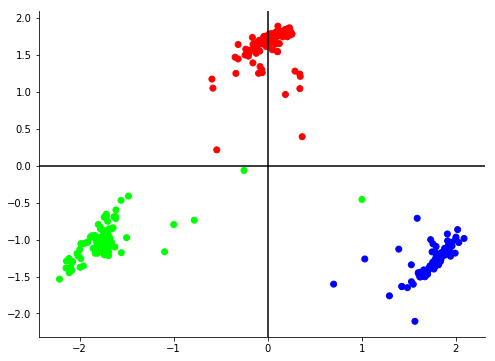

Value of beta:  0.04


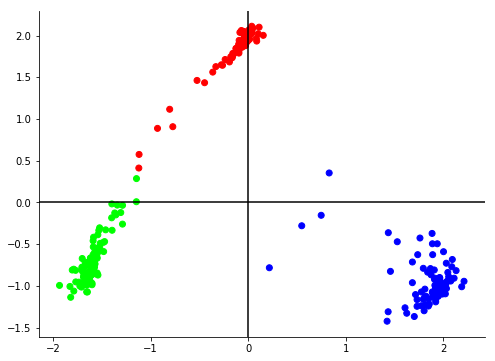

Value of beta:  0.04


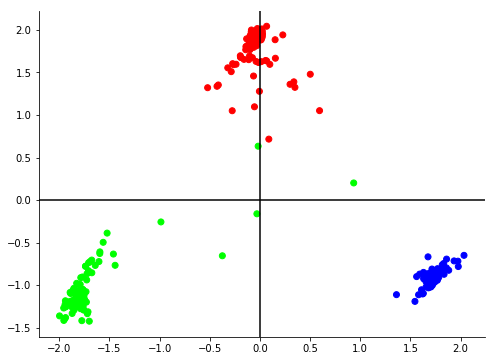

Value of beta:  0.04


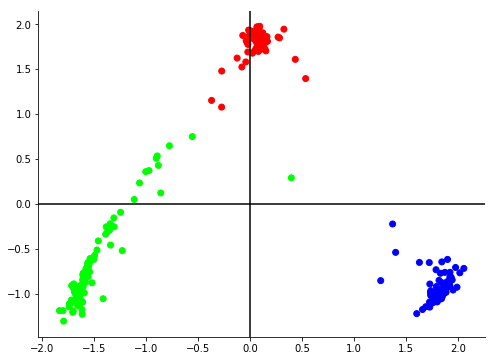

Value of beta:  0.04


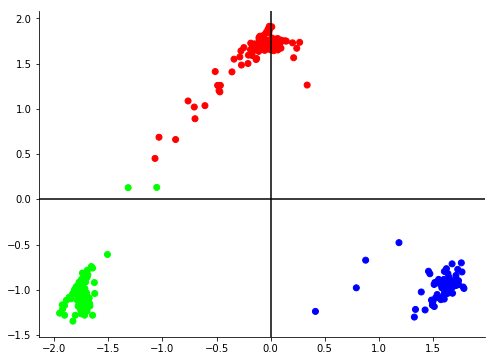

Value of beta:  0.04


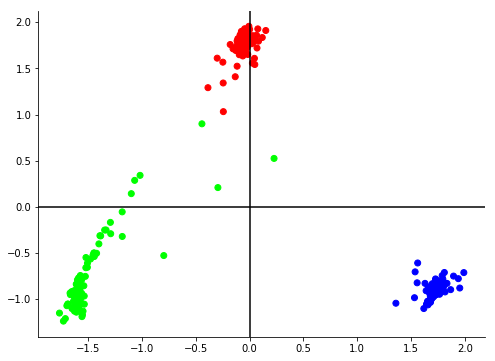

Value of beta:  0.04


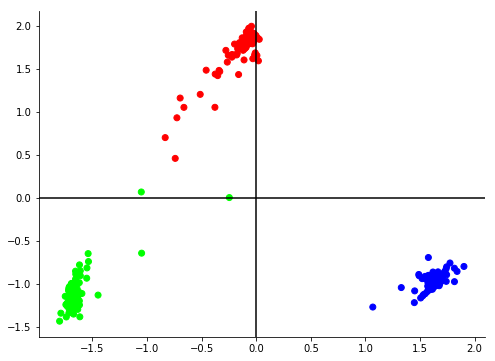

Value of beta:  0.04


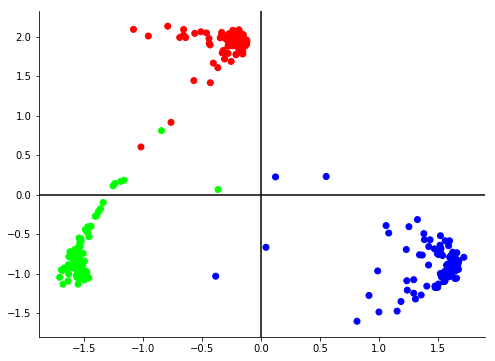

Value of beta:  0.04


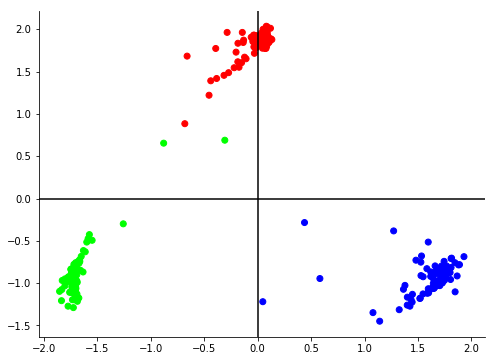

Value of beta:  0.04


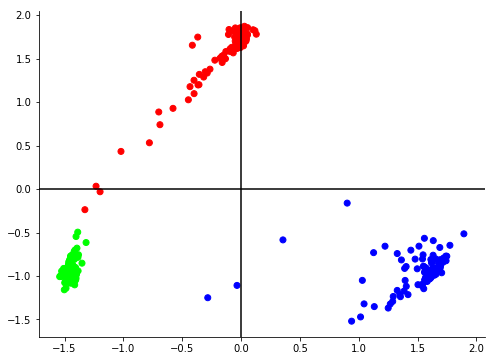

Value of beta:  0.05


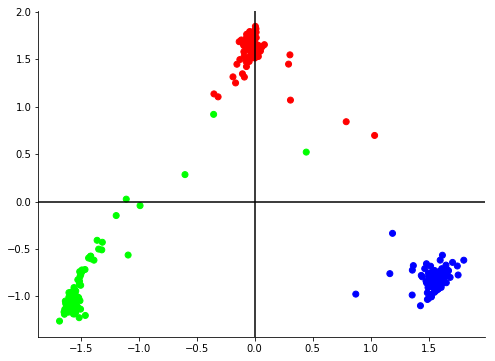

Value of beta:  0.05


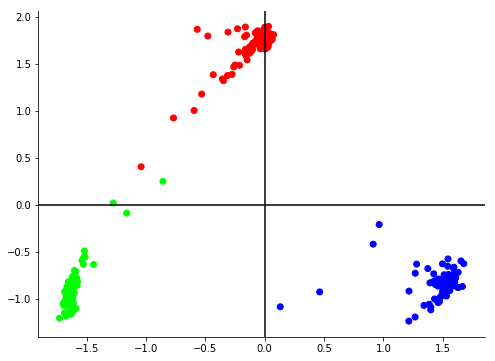

Value of beta:  0.05


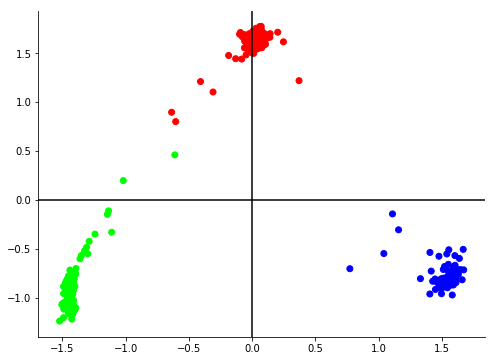

Value of beta:  0.05


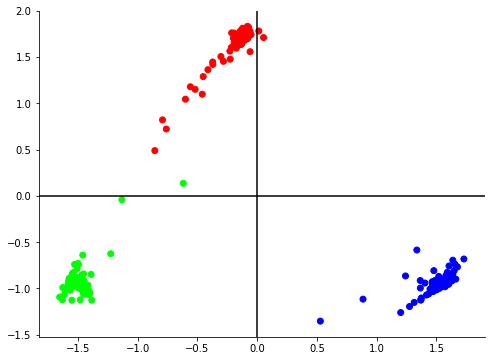

Value of beta:  0.05


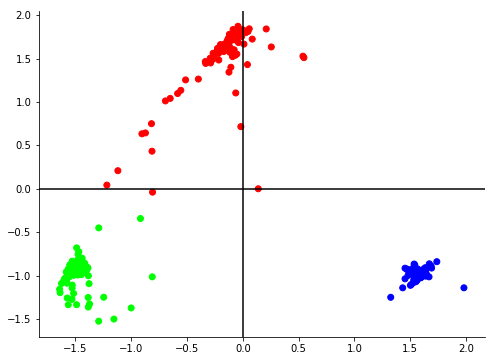

Value of beta:  0.05


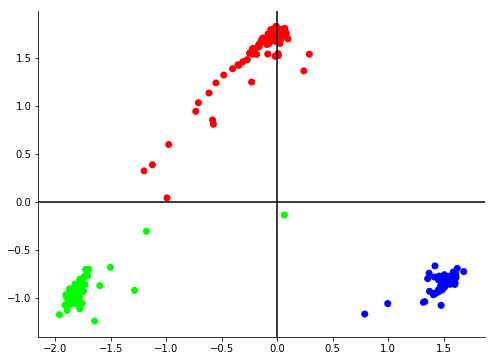

Value of beta:  0.05


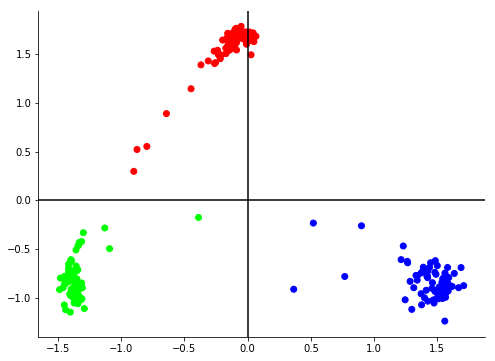

Value of beta:  0.05


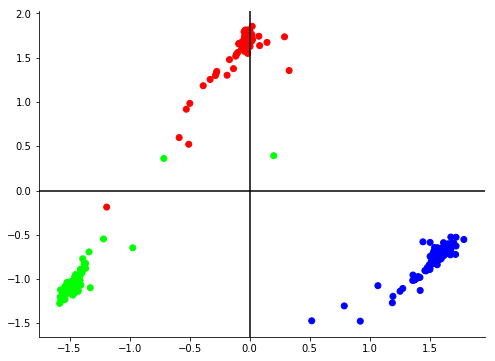

Value of beta:  0.05


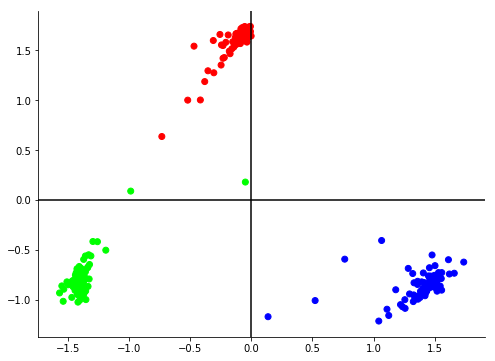

Value of beta:  0.05


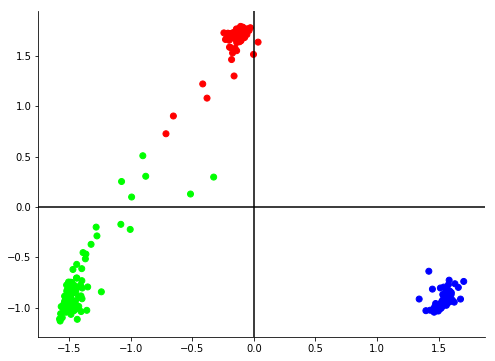

Value of beta:  0.060000002


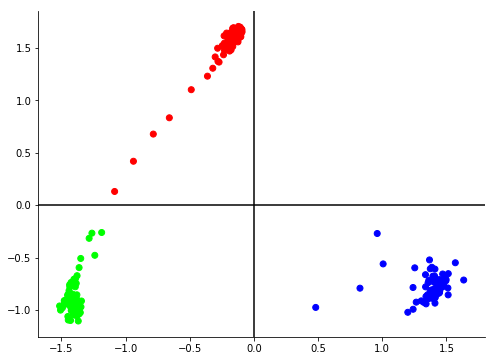

Value of beta:  0.060000002


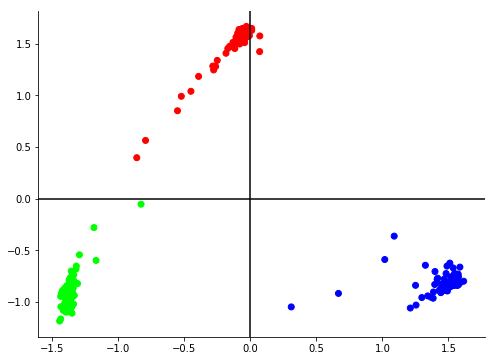

Value of beta:  0.060000002


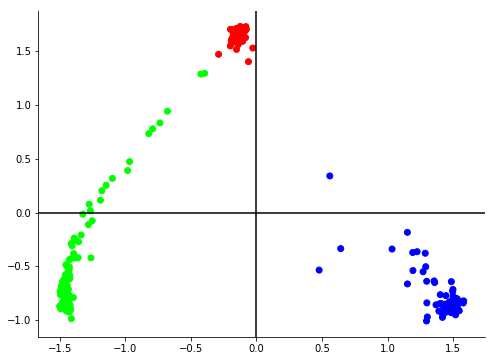

Value of beta:  0.060000002


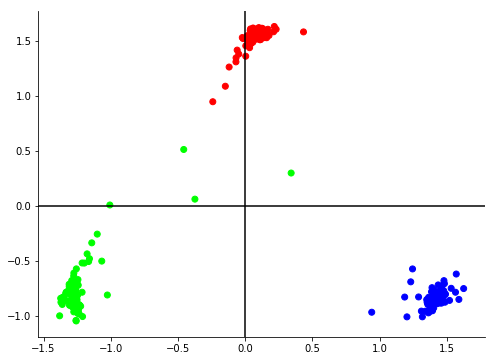

Value of beta:  0.060000002


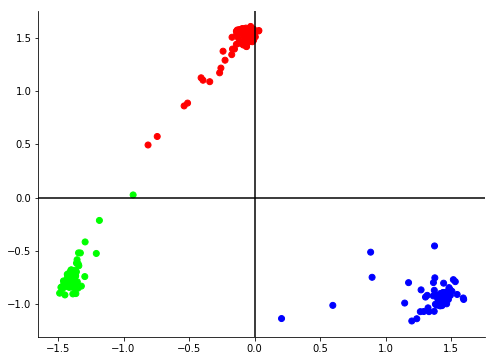

Value of beta:  0.060000002


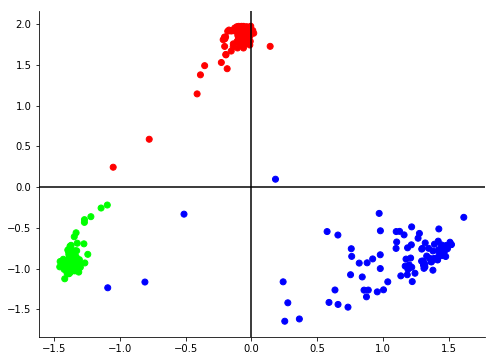

Value of beta:  0.060000002


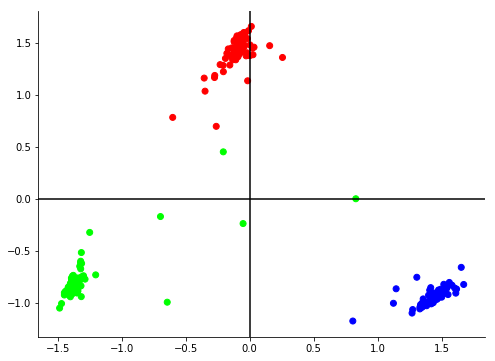

Value of beta:  0.060000002


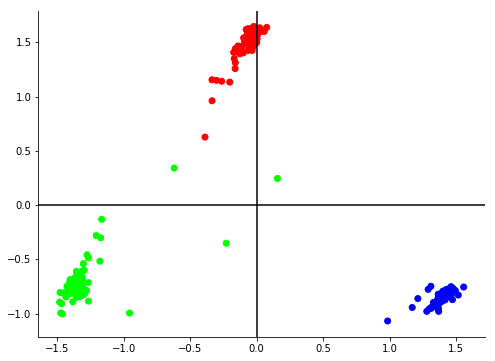

Value of beta:  0.060000002


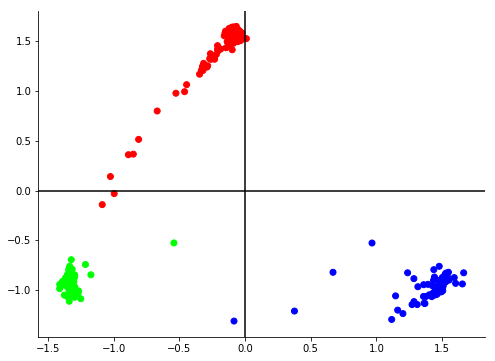

Value of beta:  0.060000002


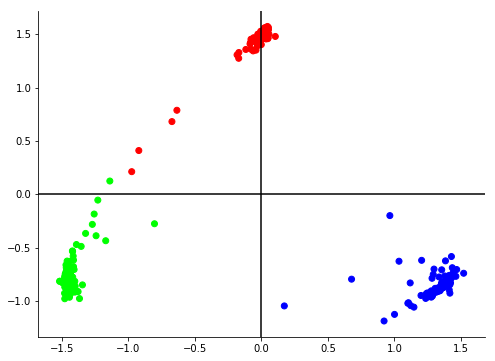

Value of beta:  0.07


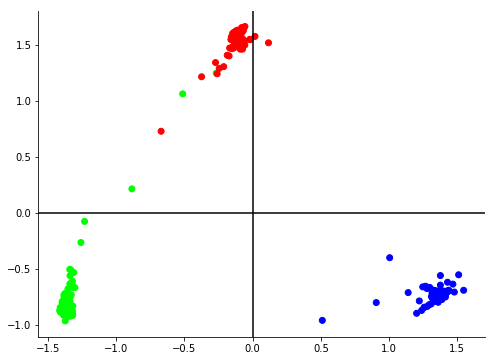

Value of beta:  0.07


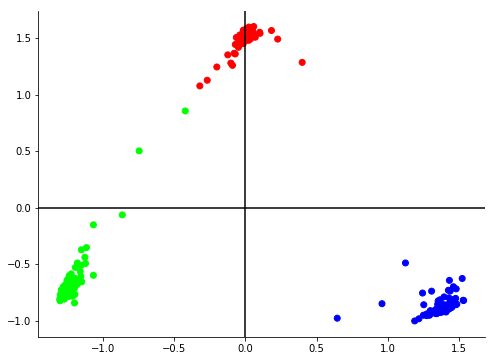

Value of beta:  0.07


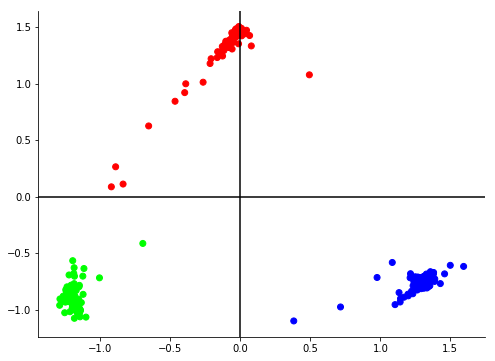

Value of beta:  0.07


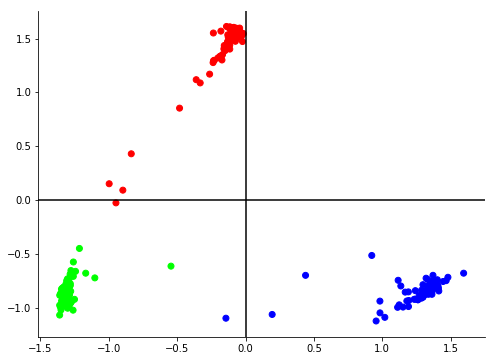

Value of beta:  0.07


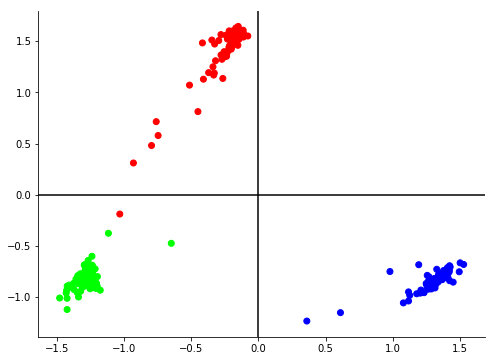

Value of beta:  0.07


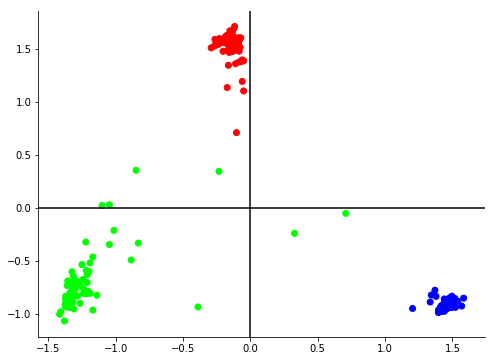

Value of beta:  0.07


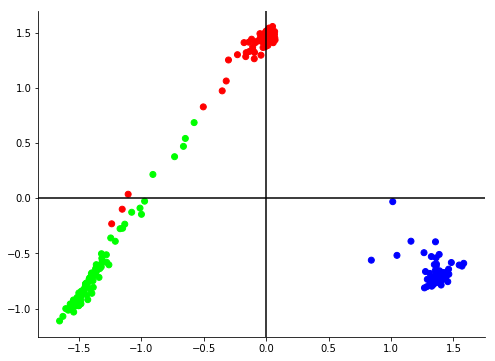

Value of beta:  0.07


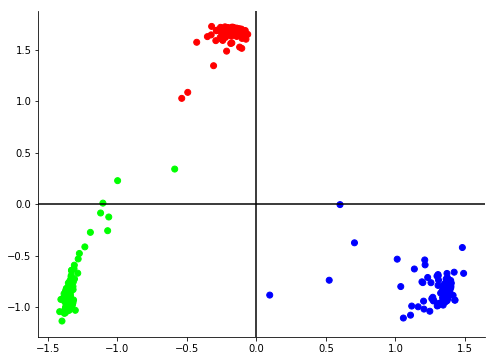

Value of beta:  0.07


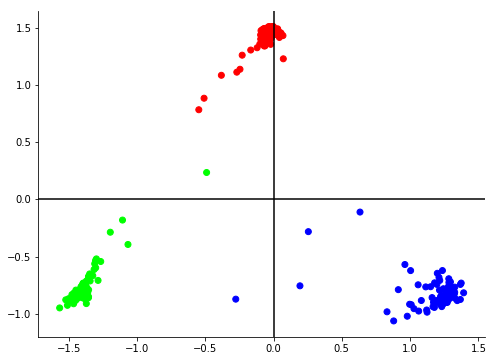

Value of beta:  0.07


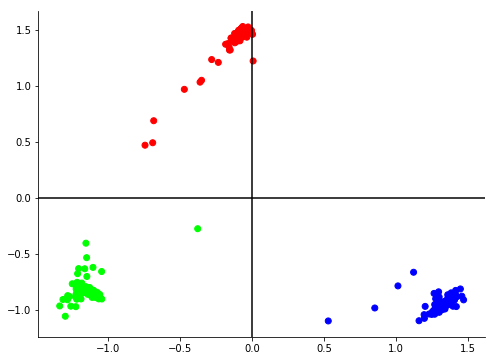

Value of beta:  0.08


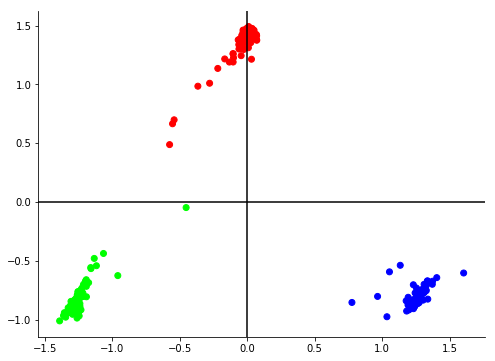

Value of beta:  0.08


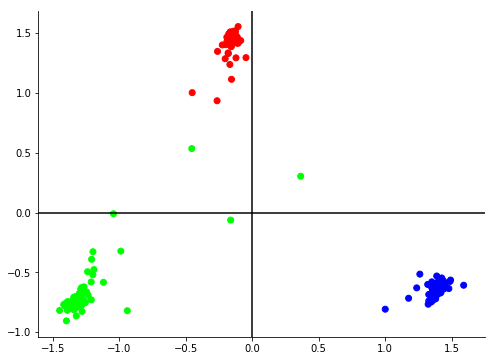

Value of beta:  0.08


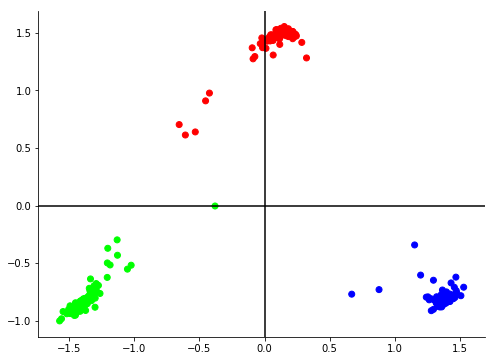

Value of beta:  0.08


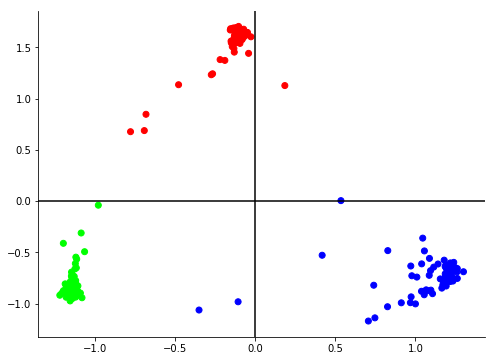

Value of beta:  0.08


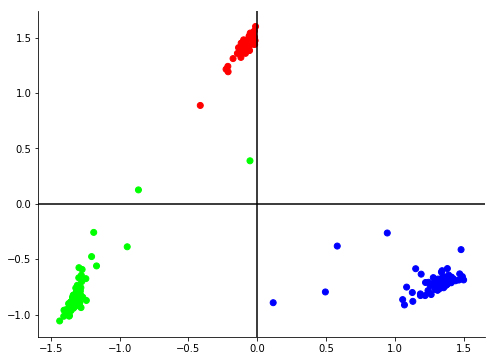

Value of beta:  0.08


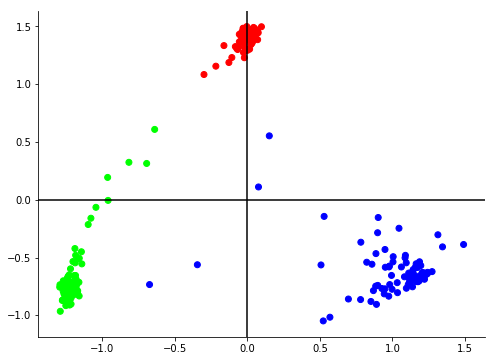

Value of beta:  0.08


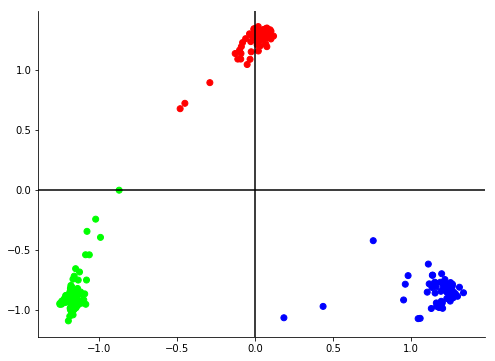

Value of beta:  0.08


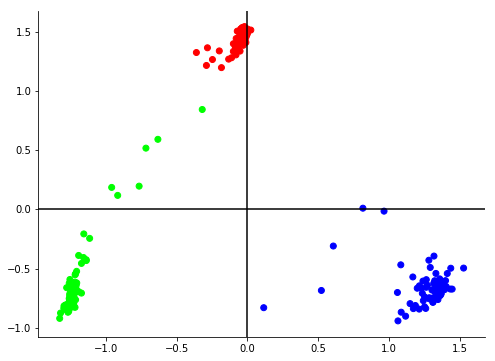

Value of beta:  0.08


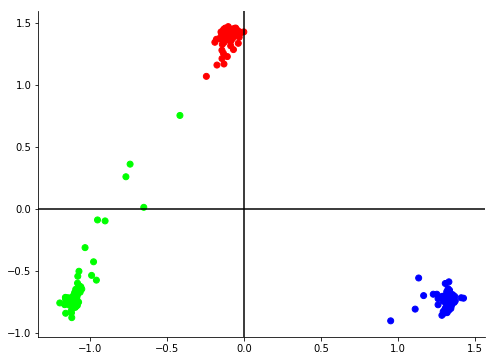

Value of beta:  0.08


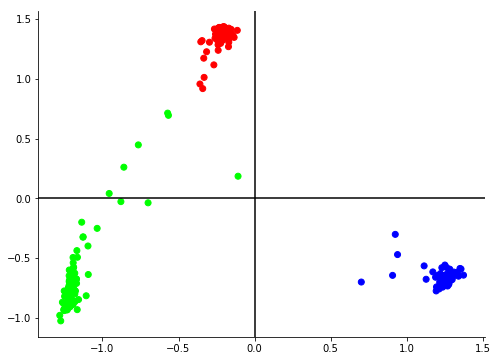

Value of beta:  0.089999996


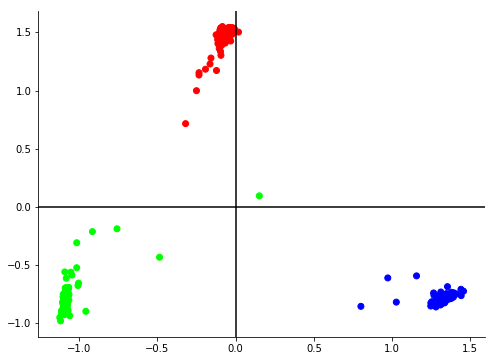

Value of beta:  0.089999996


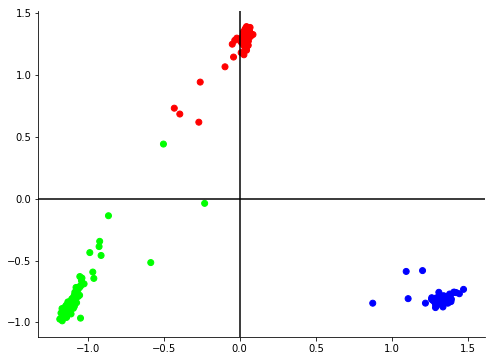

Value of beta:  0.089999996


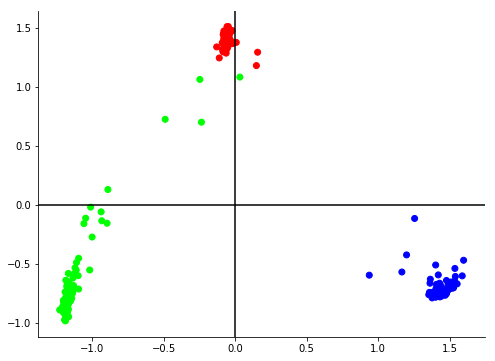

Value of beta:  0.089999996


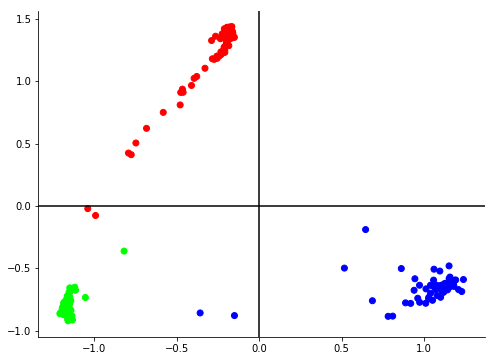

Value of beta:  0.089999996


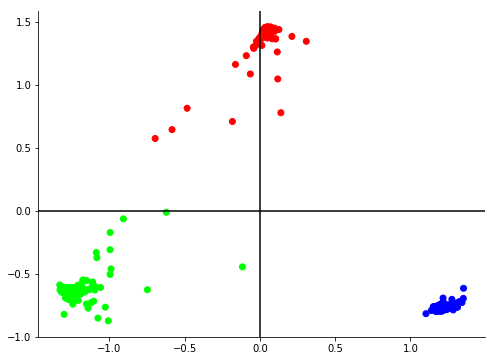

Value of beta:  0.089999996


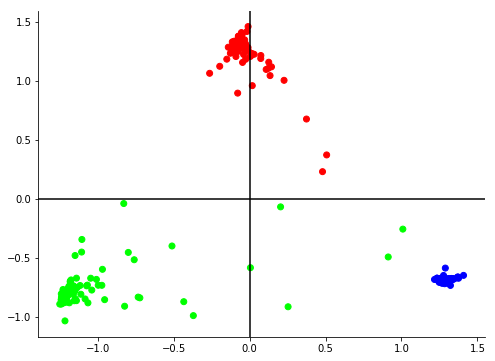

Value of beta:  0.089999996


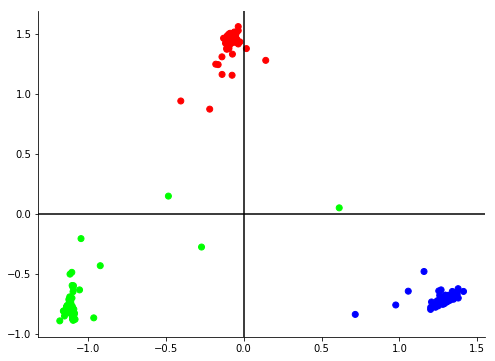

Value of beta:  0.089999996


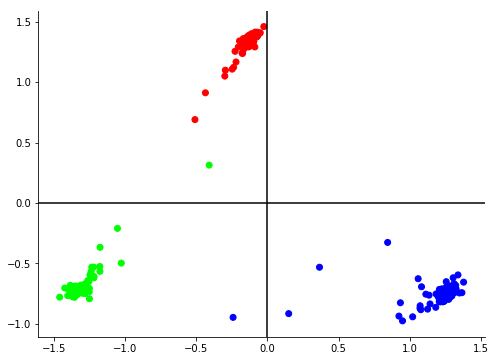

Value of beta:  0.089999996


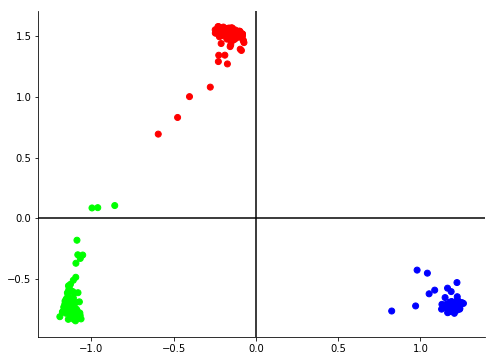

Value of beta:  0.089999996


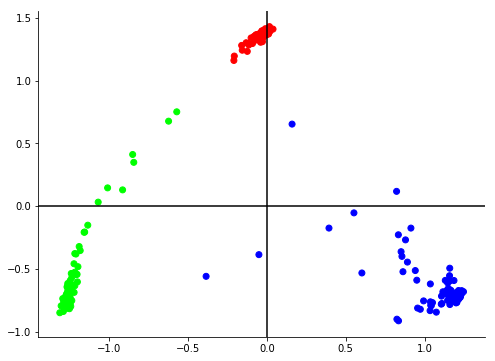


Wall time: 14min 41s


In [25]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        print('Value of beta: ', beta.numpy())
        losses = train_loop_online(model, optimizer, data_gen, iterations_per_epoch, 
                            batch_size, X_test, m_test, p_bar, beta, clip_value=clip_value, 
                            global_step=global_step, beta_update_every=1000)
        z_mean, _, _ = model(X_test, return_prob=True)
        plot_latent(z_mean, m_test)
        manager.save()

Value of beta:  0.099999994


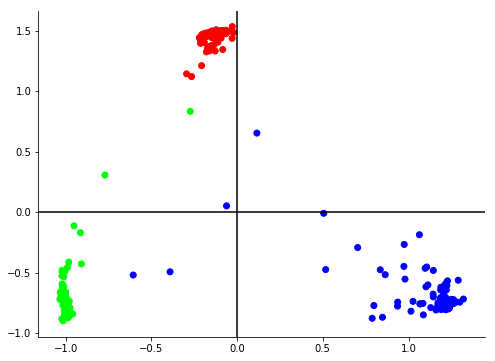

Value of beta:  0.099999994


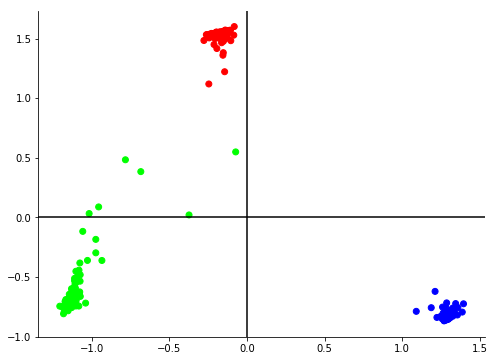

Value of beta:  0.099999994


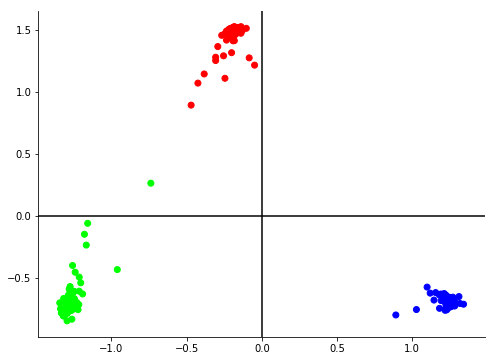

Value of beta:  0.099999994


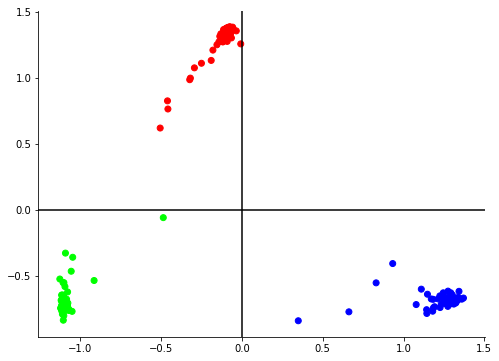

Value of beta:  0.099999994


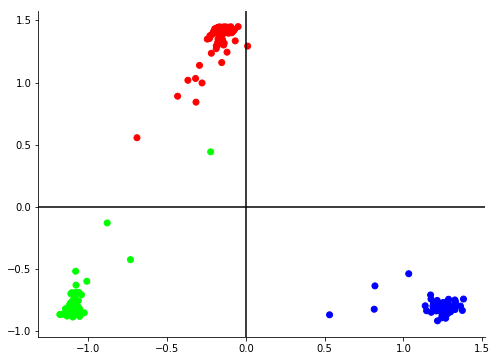

Value of beta:  0.099999994


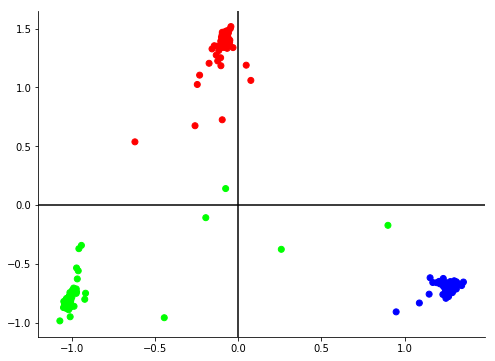

Value of beta:  0.099999994


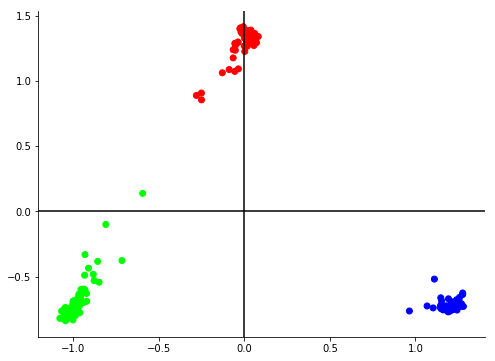

Value of beta:  0.099999994


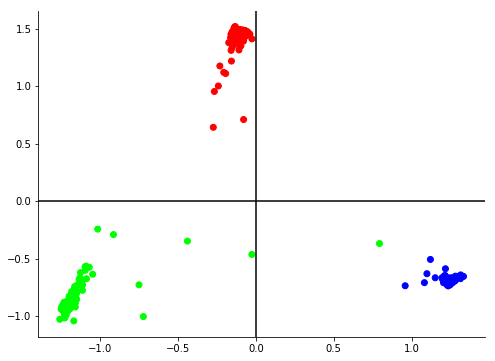

Value of beta:  0.099999994


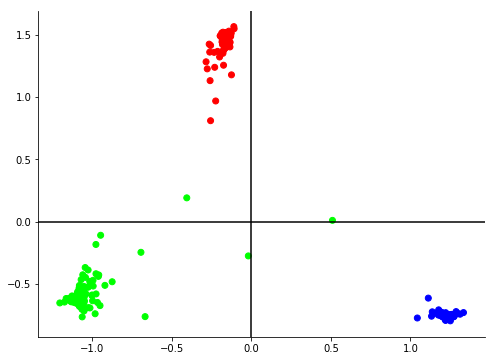

Value of beta:  0.099999994


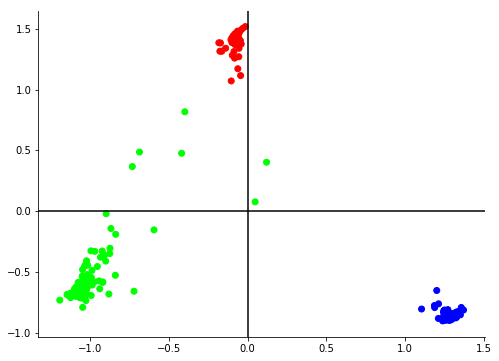

Value of beta:  0.10999999


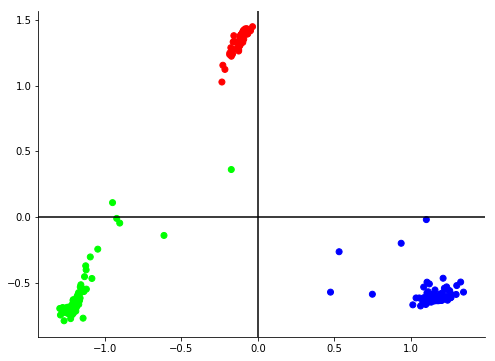

Value of beta:  0.10999999


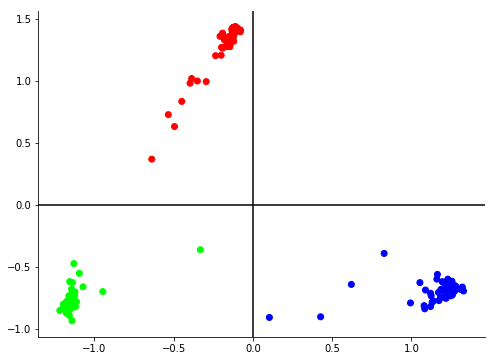

Value of beta:  0.10999999


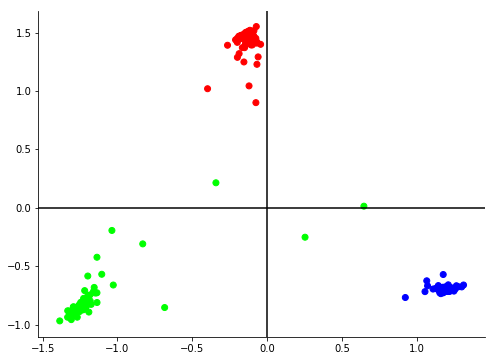

Value of beta:  0.10999999


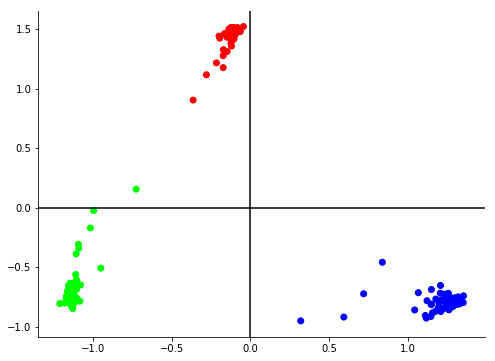

Value of beta:  0.10999999


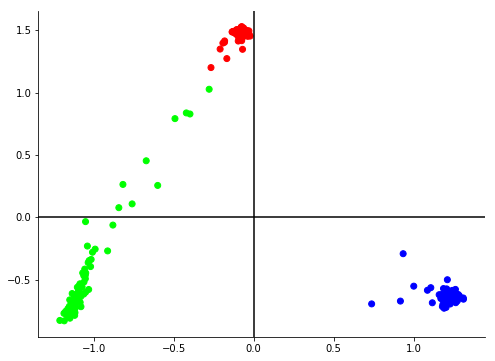

Value of beta:  0.10999999


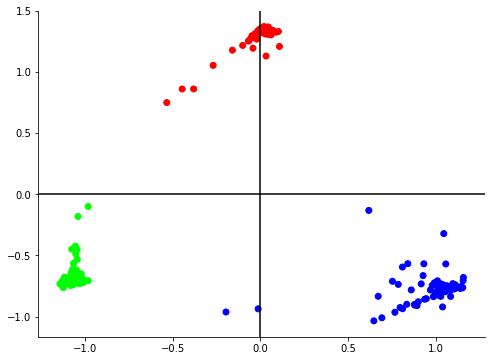

Value of beta:  0.10999999


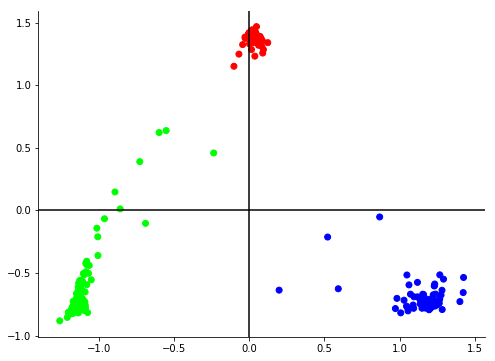

Value of beta:  0.10999999


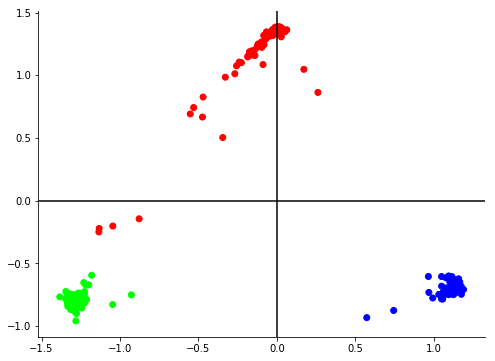

Value of beta:  0.10999999


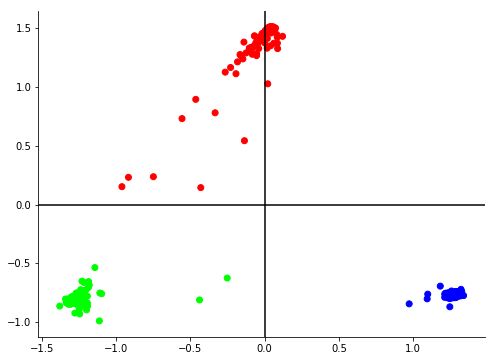

Value of beta:  0.10999999


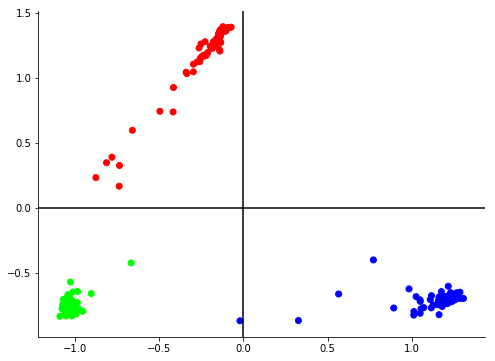

Value of beta:  0.11999999


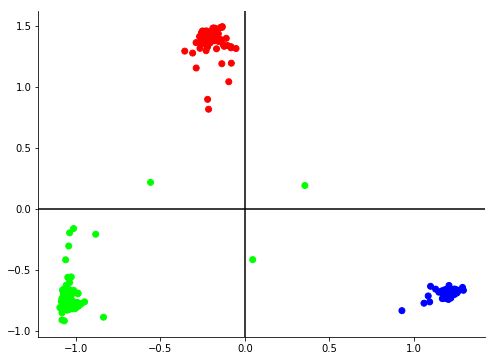

Value of beta:  0.11999999


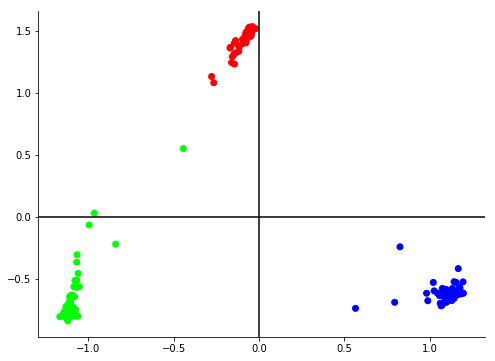

Value of beta:  0.11999999


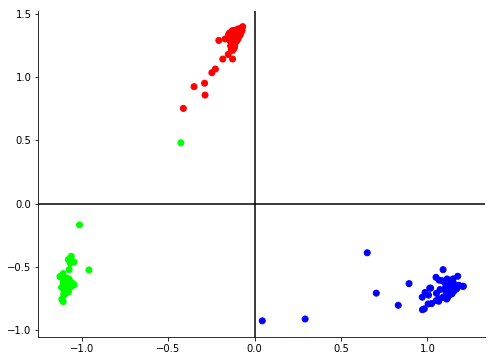

Value of beta:  0.11999999


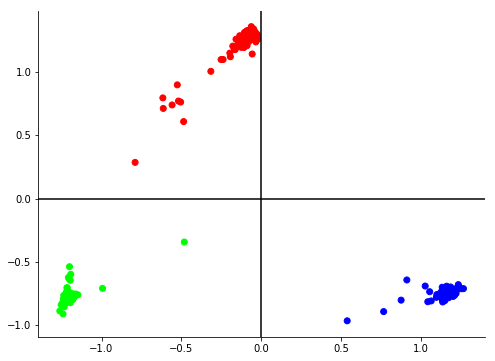

Value of beta:  0.11999999


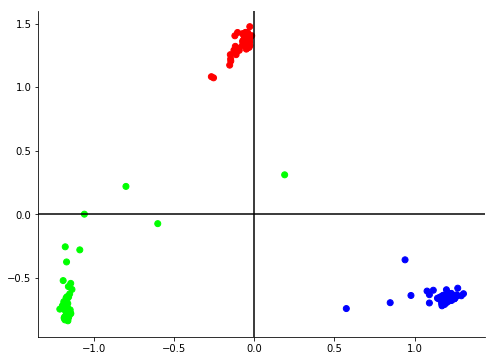

Value of beta:  0.11999999


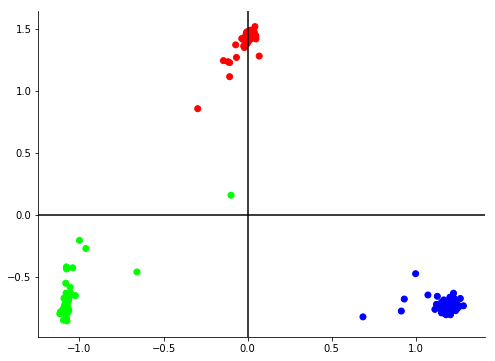

Value of beta:  0.11999999


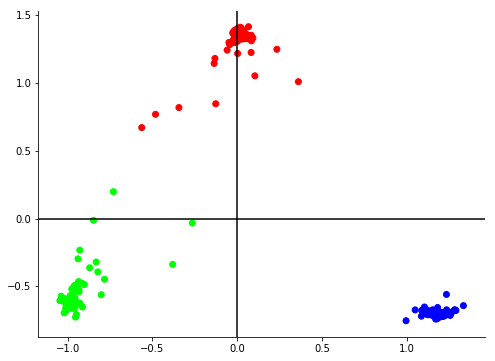

Value of beta:  0.11999999


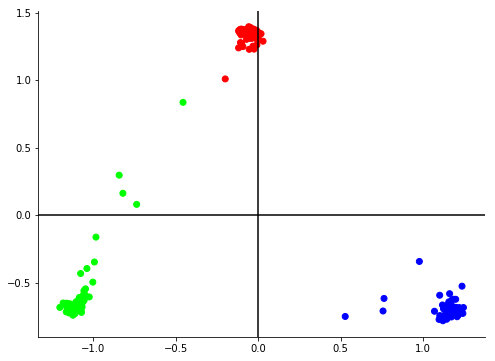

Value of beta:  0.11999999


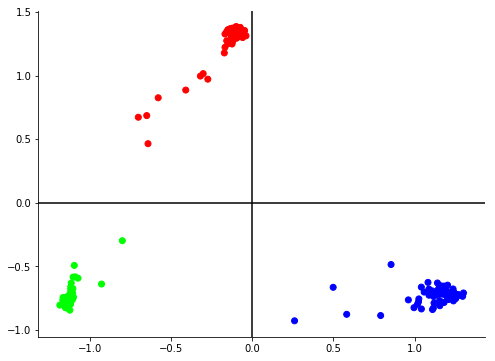

Value of beta:  0.11999999


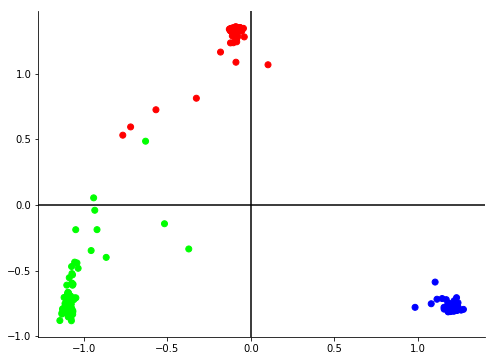

Value of beta:  0.13


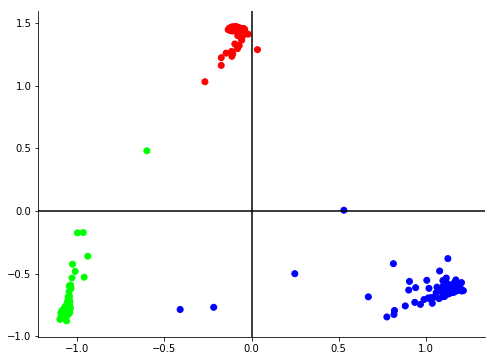

Value of beta:  0.13


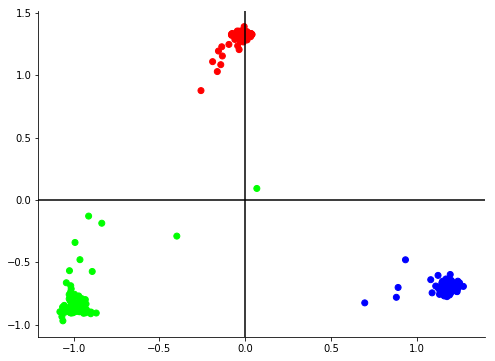

Value of beta:  0.13


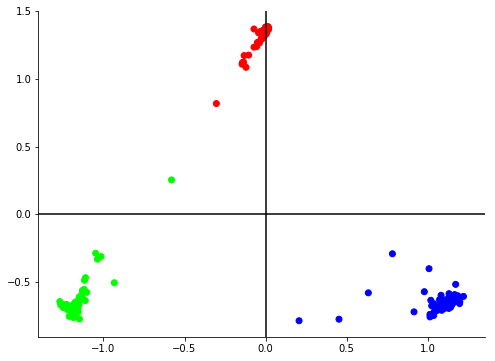

Value of beta:  0.13


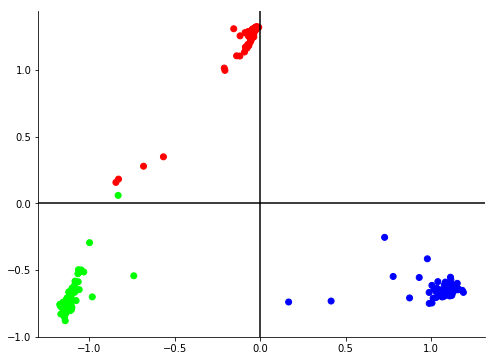

Value of beta:  0.13


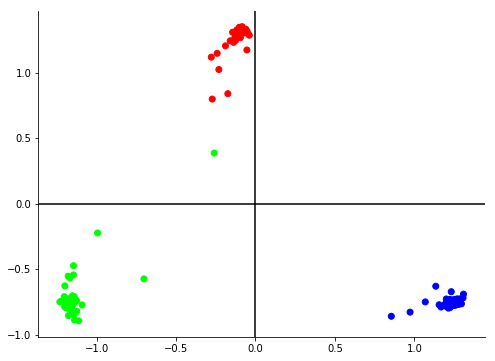

Value of beta:  0.13


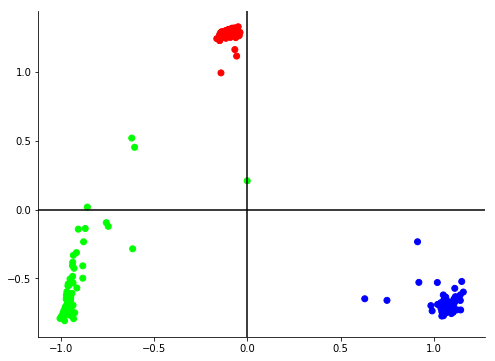

Value of beta:  0.13


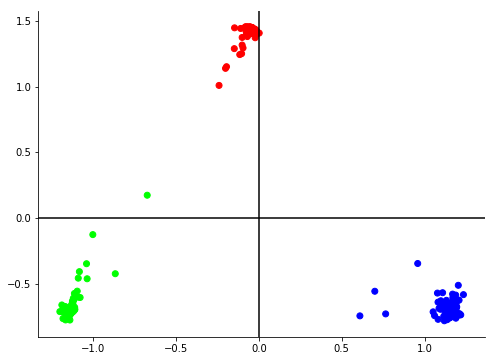

Value of beta:  0.13


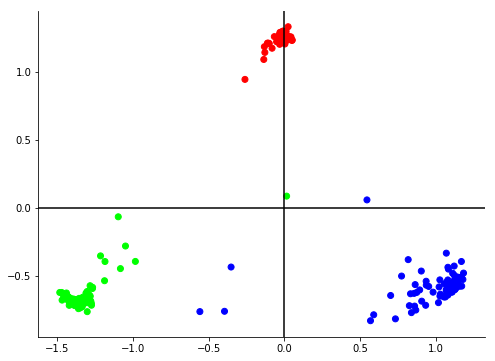

Value of beta:  0.13


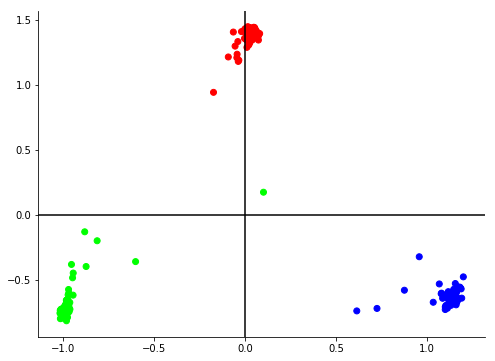

Value of beta:  0.13


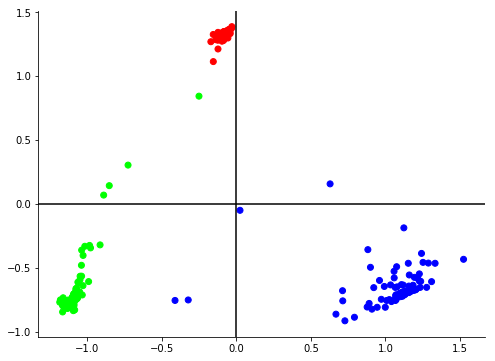

Value of beta:  0.14


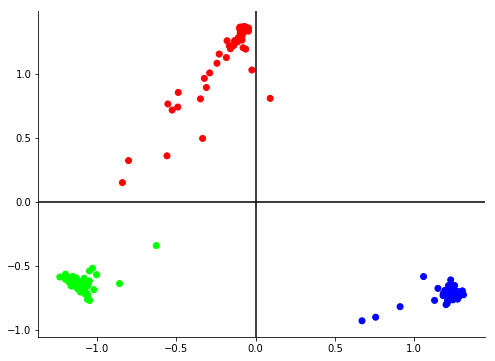

Value of beta:  0.14


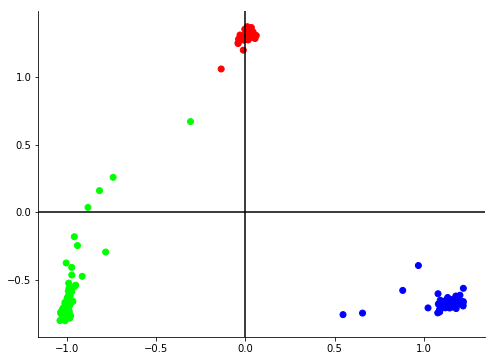

Value of beta:  0.14


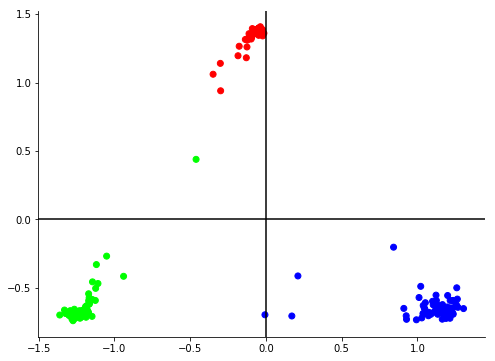

Value of beta:  0.14


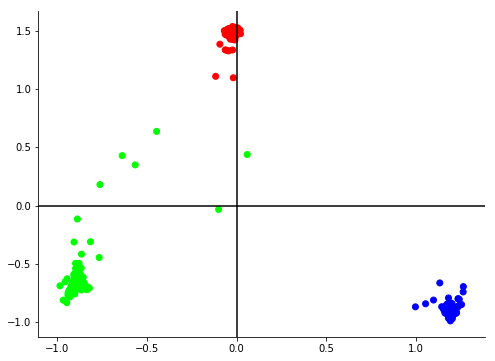

Value of beta:  0.14


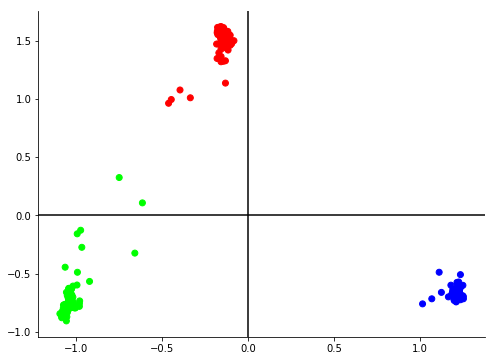

Value of beta:  0.14


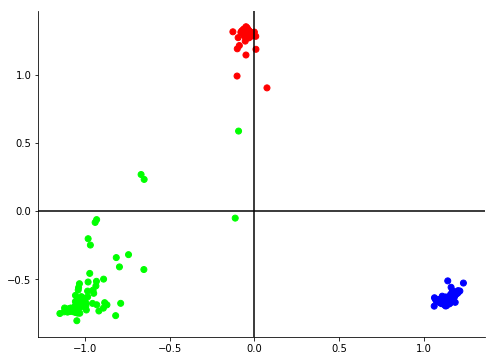

Value of beta:  0.14


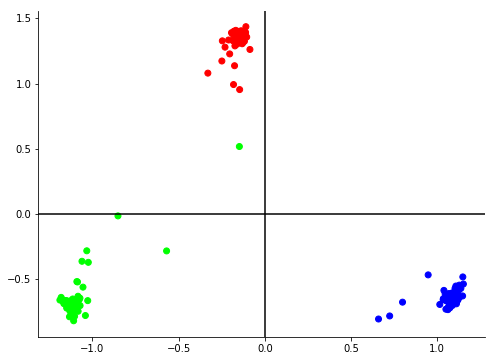

Value of beta:  0.14


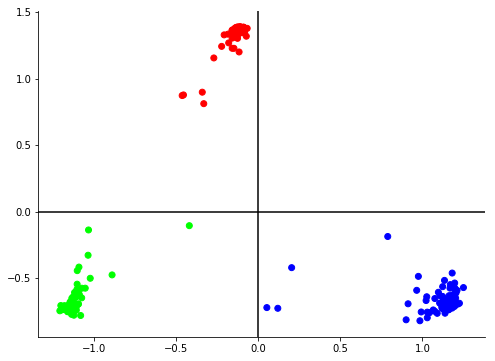

Value of beta:  0.14


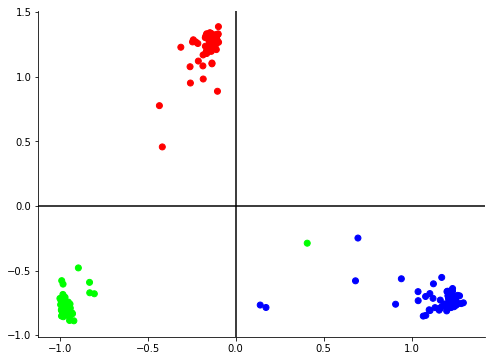

Value of beta:  0.14


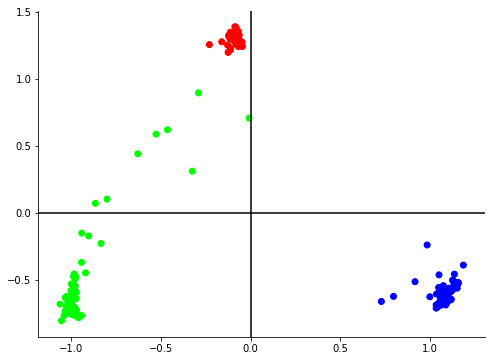

Value of beta:  0.15


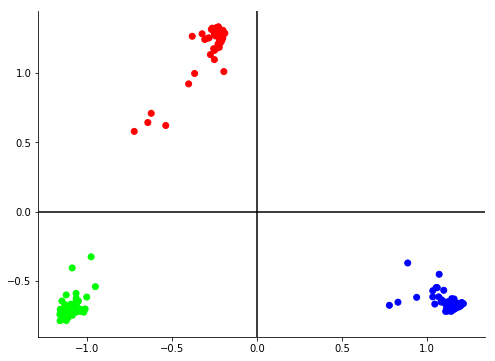

Value of beta:  0.15


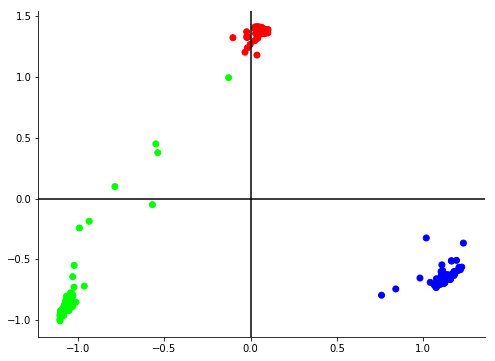

Value of beta:  0.15


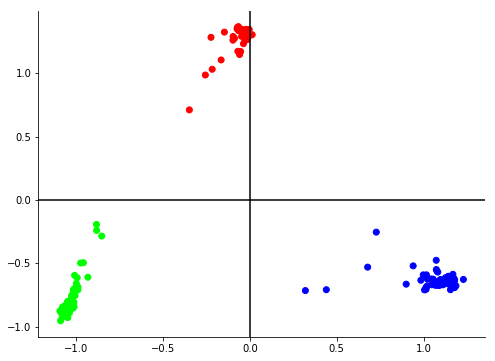

Value of beta:  0.15


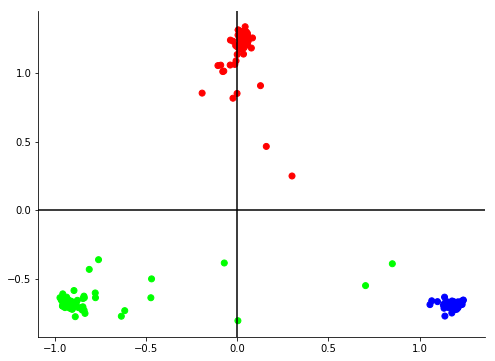

Value of beta:  0.15


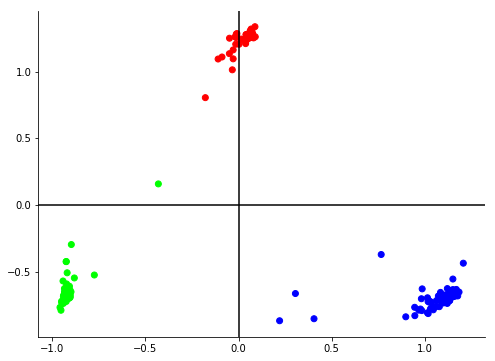

Value of beta:  0.15


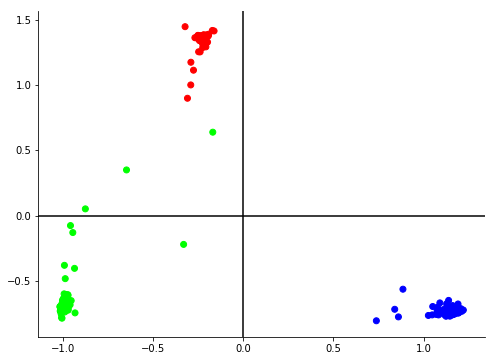

Value of beta:  0.15


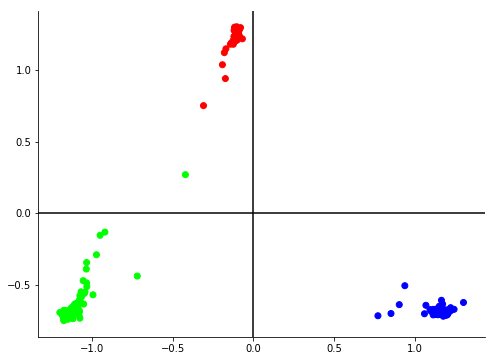

Value of beta:  0.15


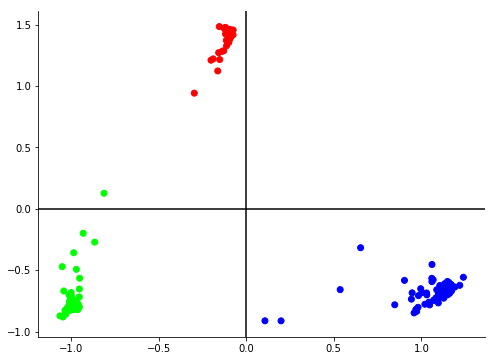

Value of beta:  0.15


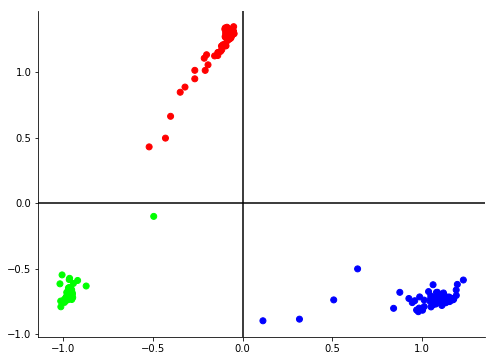

Value of beta:  0.15


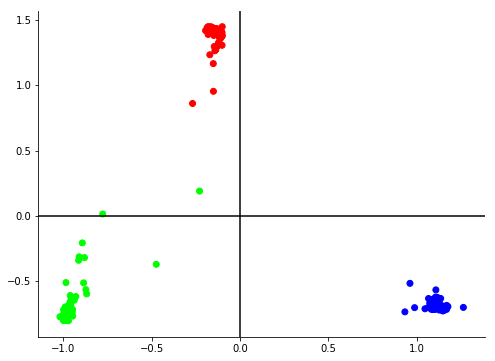

Value of beta:  0.16000001


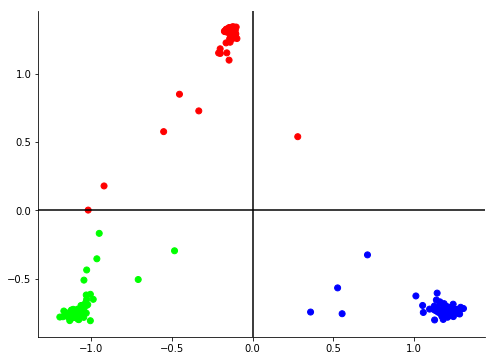

Value of beta:  0.16000001


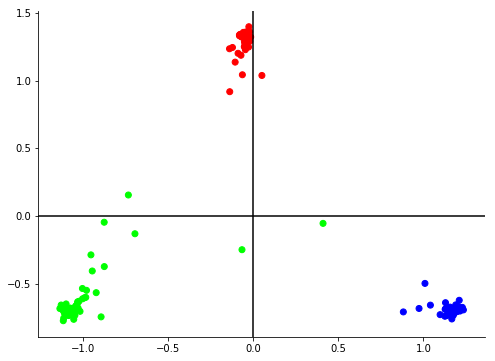

Value of beta:  0.16000001


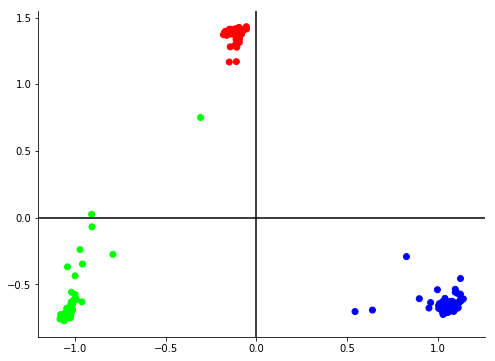

Value of beta:  0.16000001


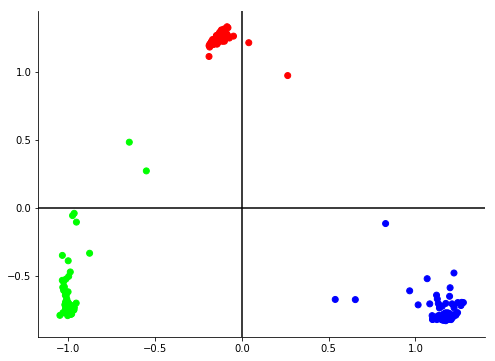

Value of beta:  0.16000001


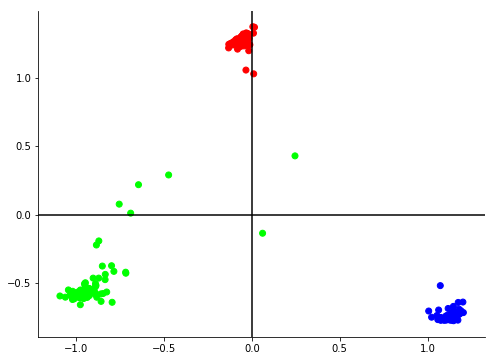

Value of beta:  0.16000001


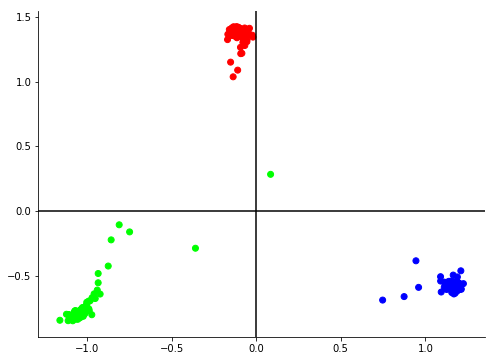

Value of beta:  0.16000001


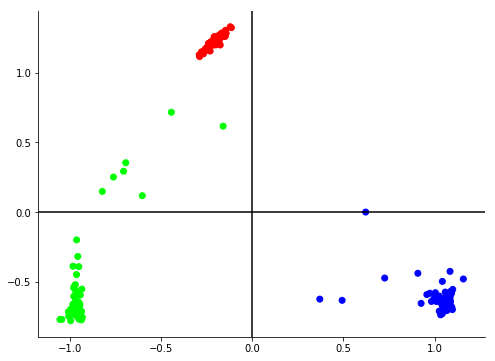

Value of beta:  0.16000001


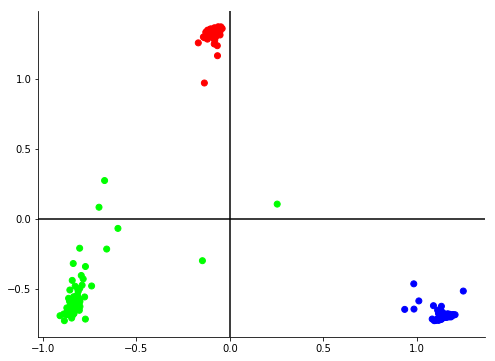

Value of beta:  0.16000001


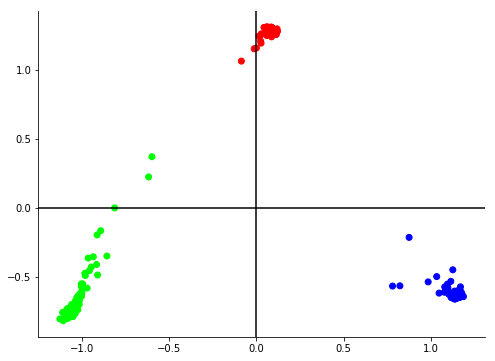

Value of beta:  0.16000001


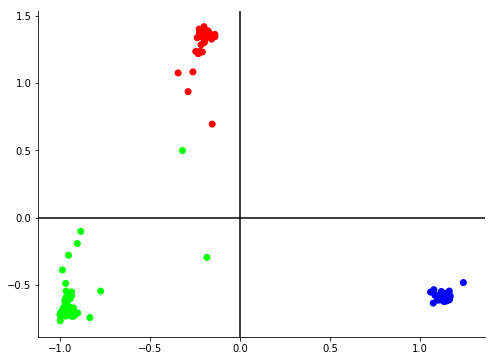

Value of beta:  0.17000002


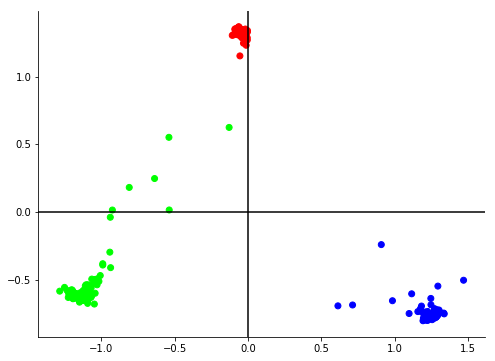

Value of beta:  0.17000002


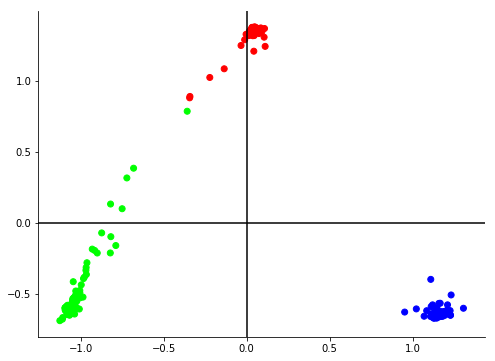

Value of beta:  0.17000002


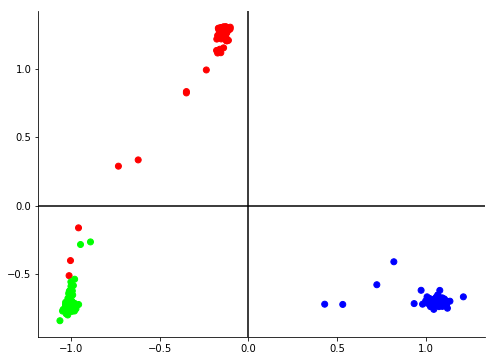

Value of beta:  0.17000002


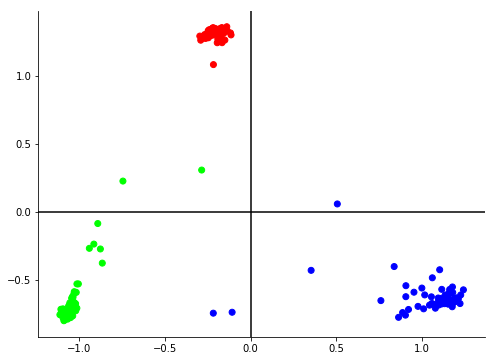

Value of beta:  0.17000002


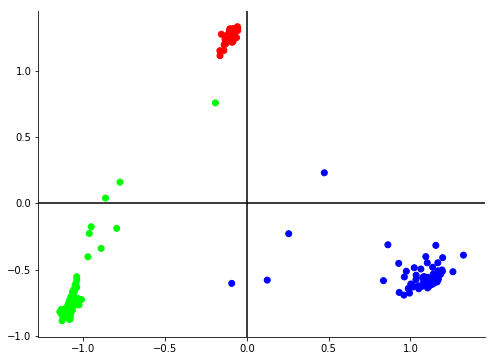

Value of beta:  0.17000002


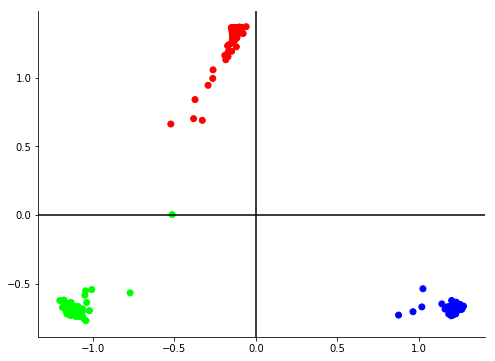

Value of beta:  0.17000002


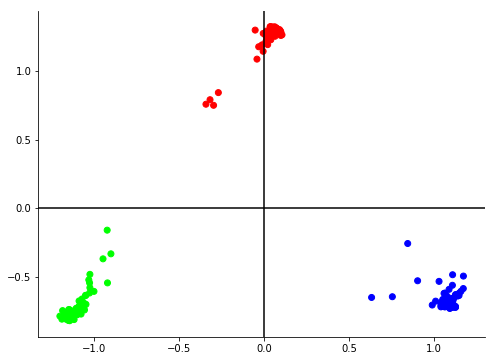

Value of beta:  0.17000002


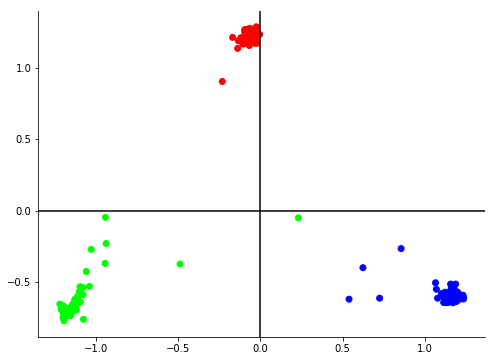

Value of beta:  0.17000002


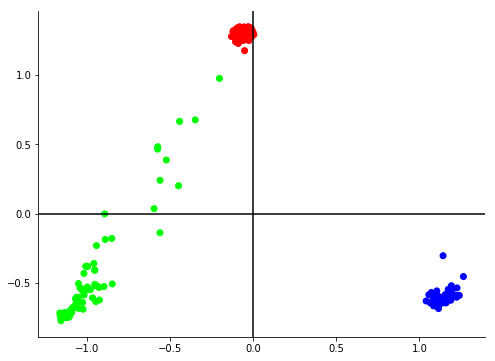

Value of beta:  0.17000002


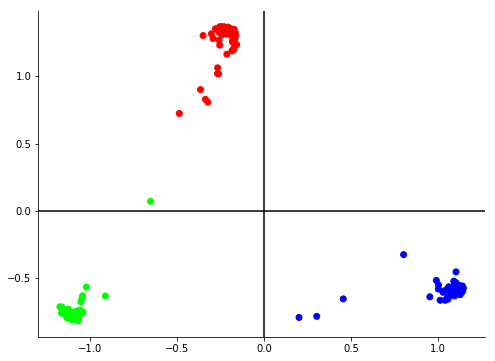

Value of beta:  0.18000002


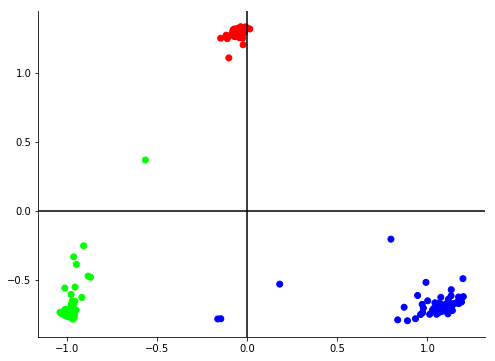

Value of beta:  0.18000002


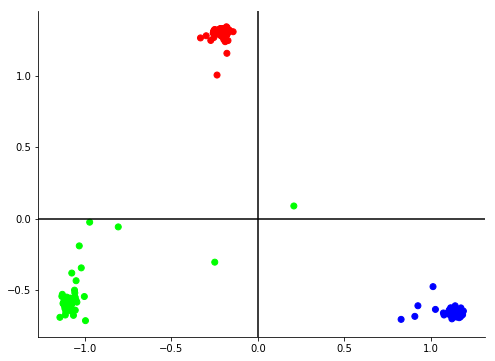

Value of beta:  0.18000002


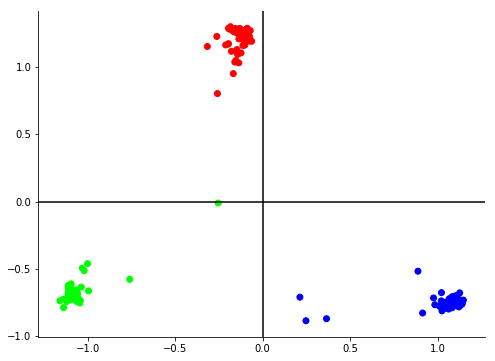

Value of beta:  0.18000002


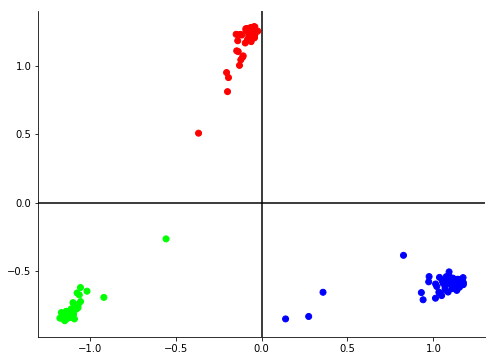

Value of beta:  0.18000002


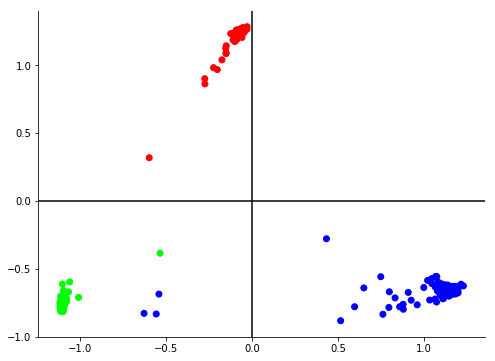

Value of beta:  0.18000002


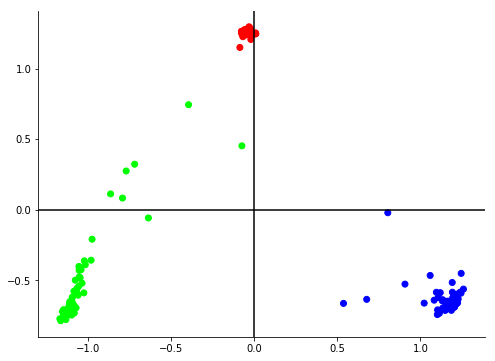

Value of beta:  0.18000002


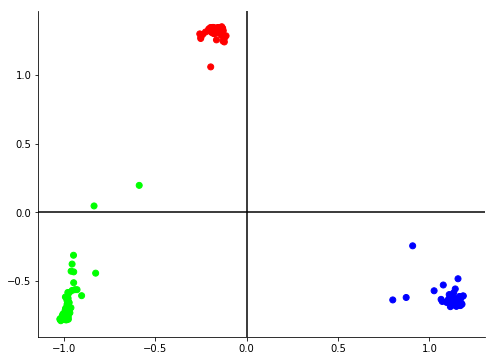

Value of beta:  0.18000002


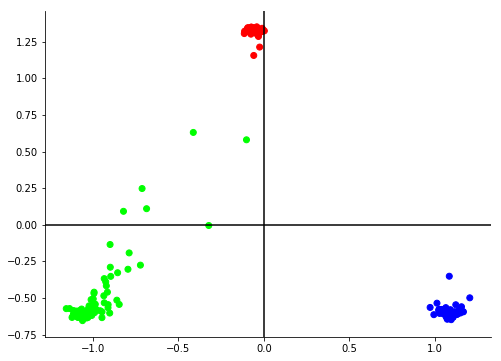

Value of beta:  0.18000002


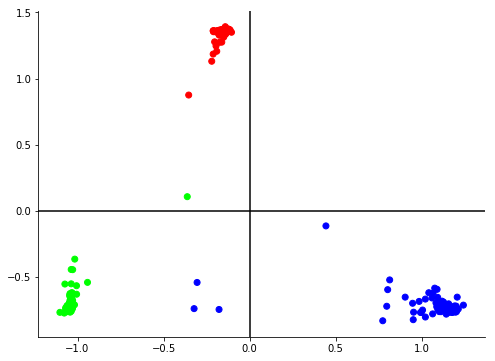

Value of beta:  0.18000002


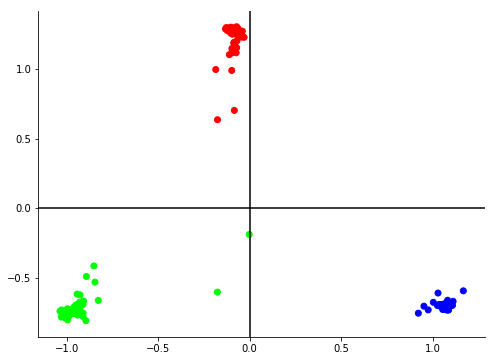

Value of beta:  0.19000003


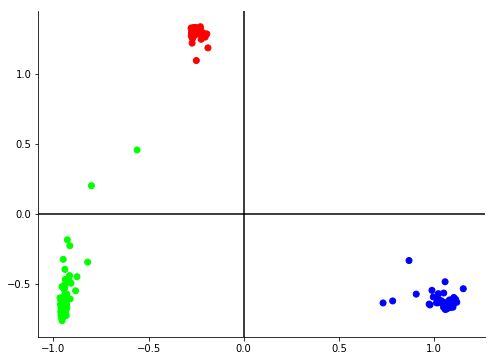

Value of beta:  0.19000003


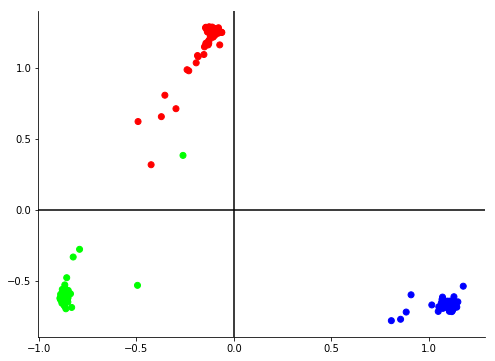

Value of beta:  0.19000003


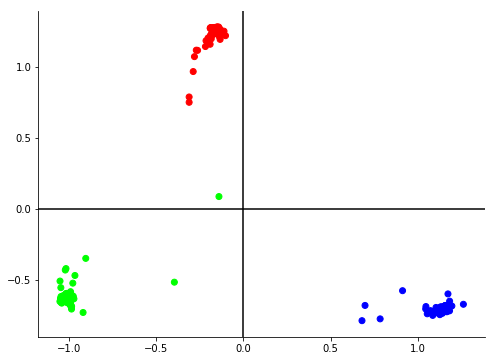

Value of beta:  0.19000003


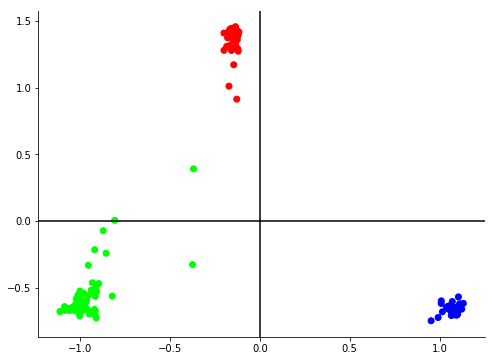

Value of beta:  0.19000003


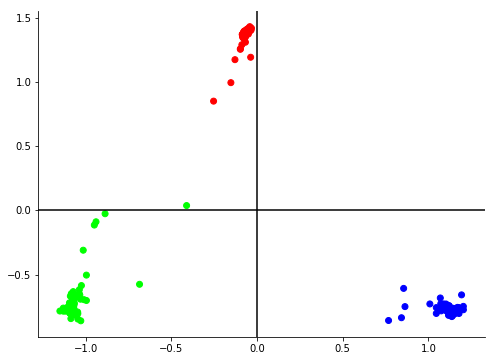

Value of beta:  0.19000003


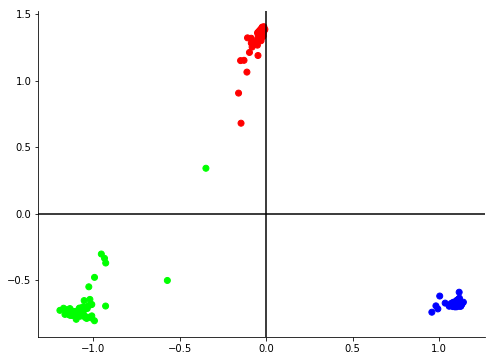

Value of beta:  0.19000003


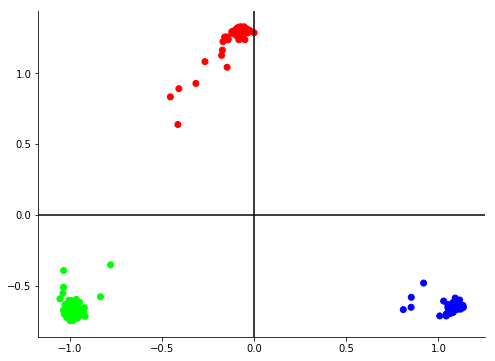

Value of beta:  0.19000003


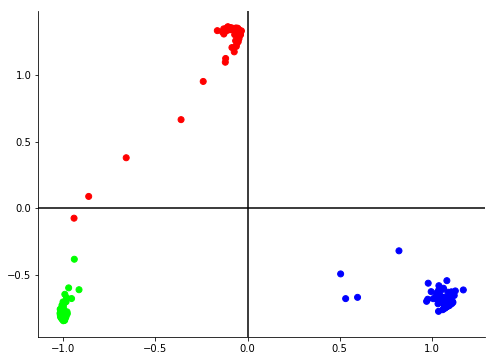

Value of beta:  0.19000003


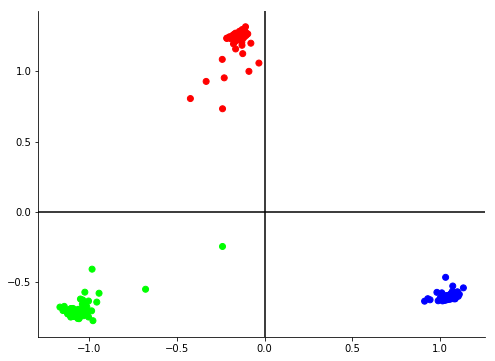

Value of beta:  0.19000003


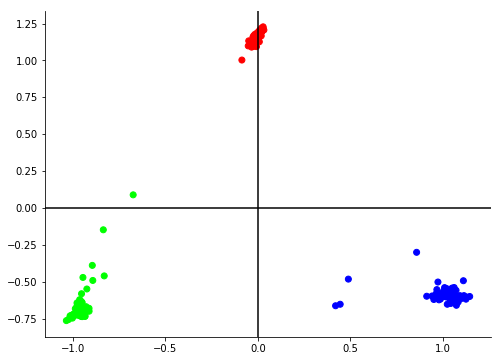


Wall time: 13min 44s


In [26]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        print('Value of beta: ', beta.numpy())
        losses = train_loop_online(model, optimizer, data_gen, iterations_per_epoch, 
                            batch_size, X_test, m_test, p_bar, beta, clip_value=clip_value, 
                            global_step=global_step, beta_update_every=1000)
        z_mean, _, _ = model(X_test, return_prob=True)
        plot_latent(z_mean, m_test)
        manager.save()

Value of beta:  0.2


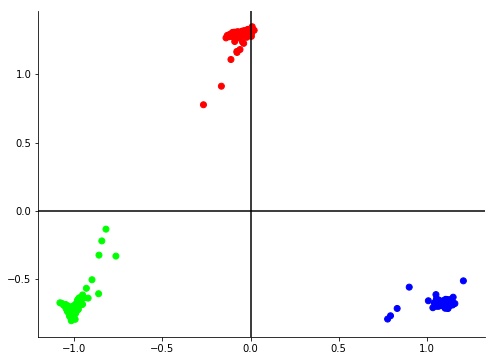

Value of beta:  0.2


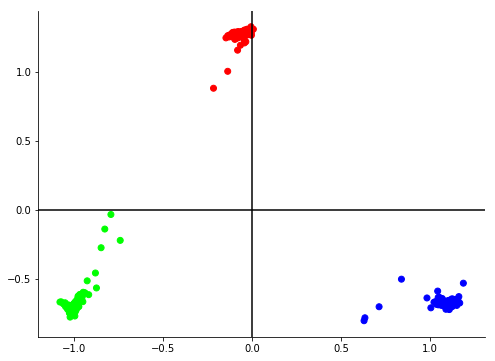

Value of beta:  0.2


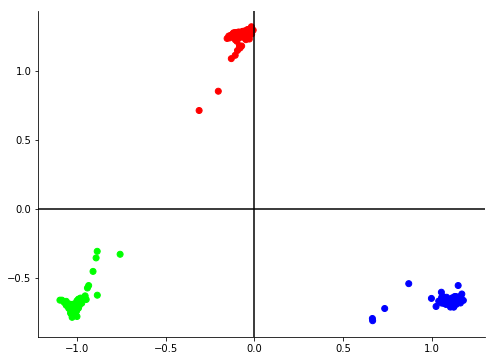

Value of beta:  0.2


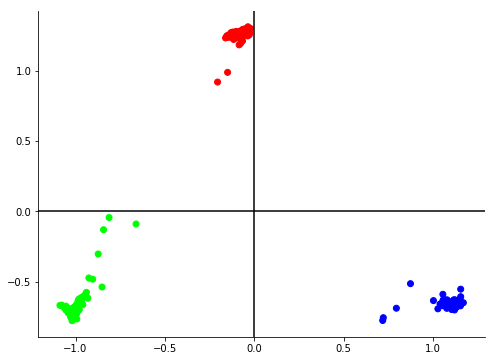

Value of beta:  0.2


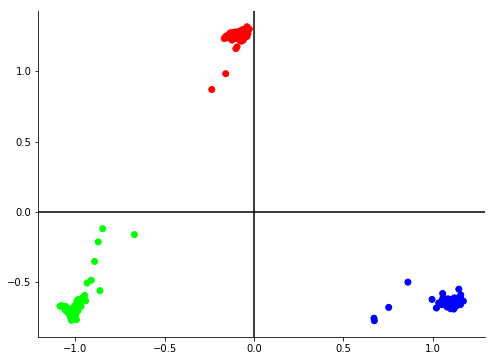

Value of beta:  0.2


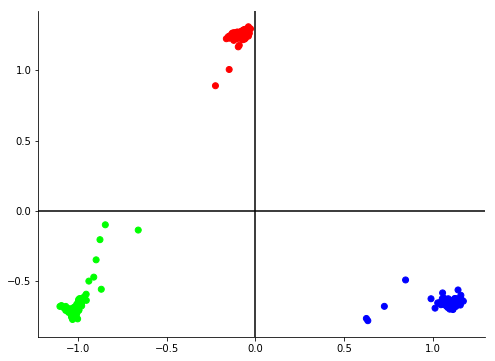

Value of beta:  0.2


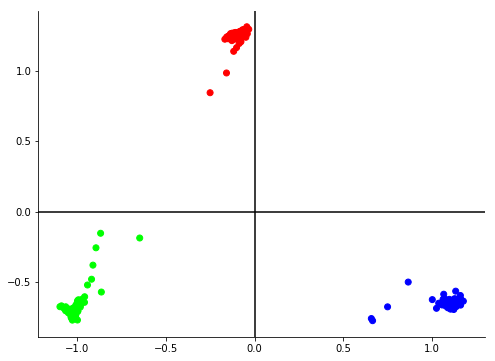

Value of beta:  0.2


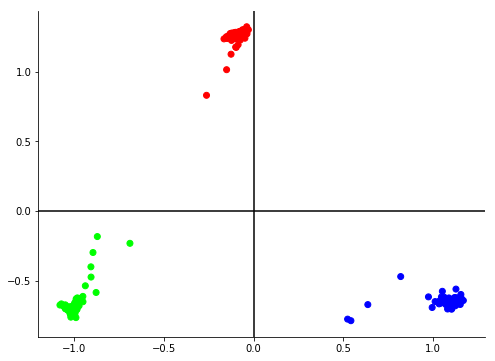

Value of beta:  0.2


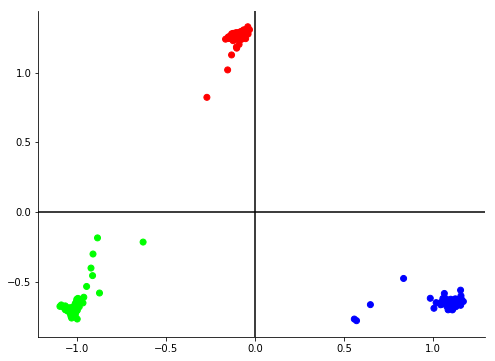

Value of beta:  0.2


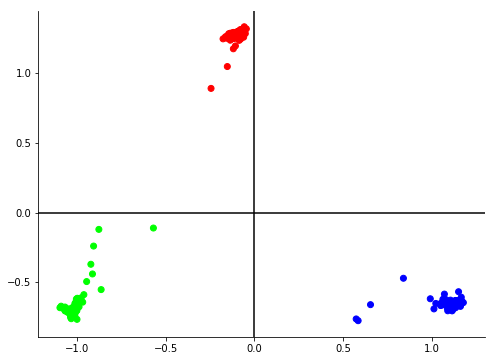

Value of beta:  0.2


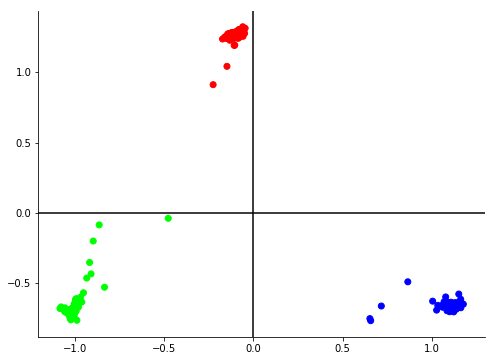

Value of beta:  0.2


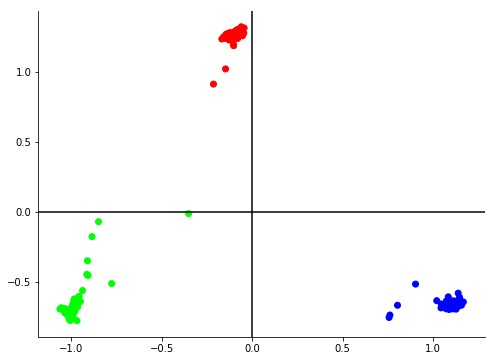

Value of beta:  0.2


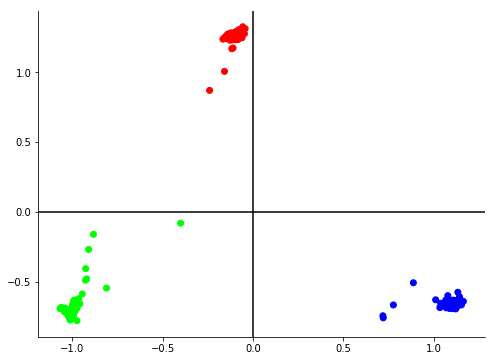

Value of beta:  0.2


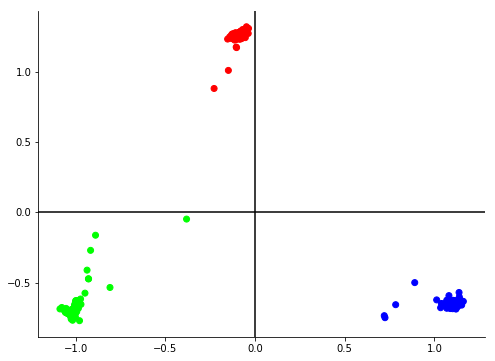

Value of beta:  0.2


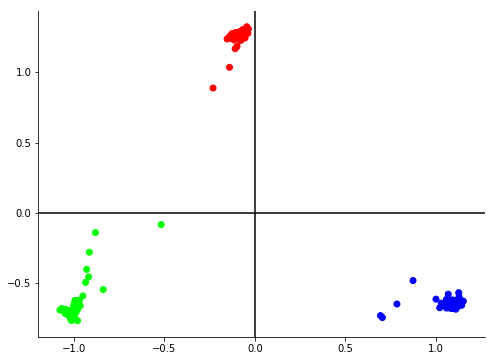

Value of beta:  0.2


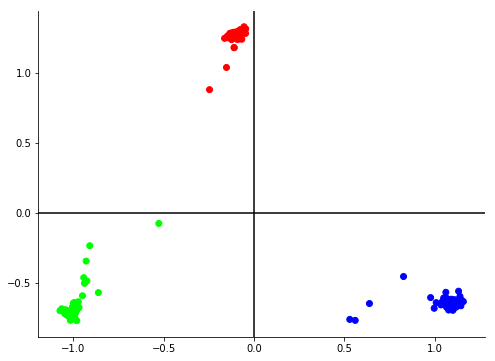

Value of beta:  0.2


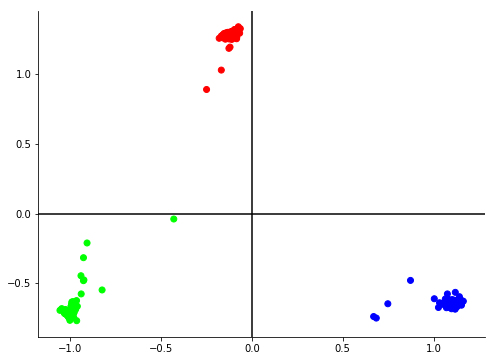

Value of beta:  0.2


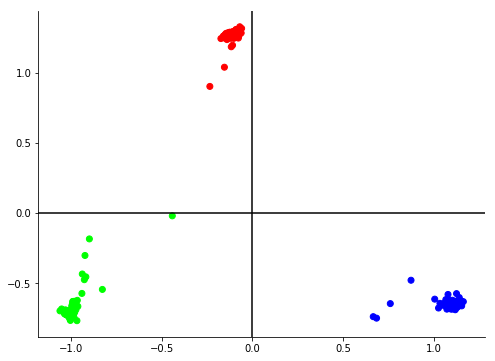

Value of beta:  0.2


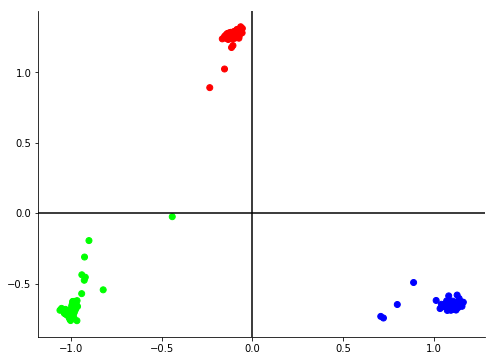

Value of beta:  0.2


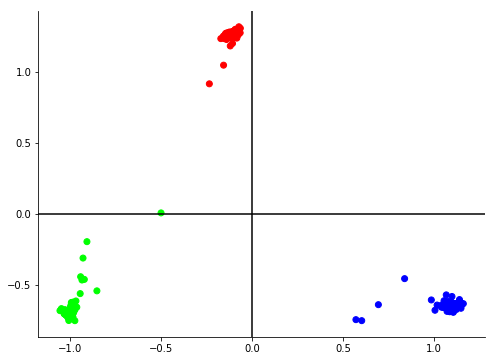

Value of beta:  0.2


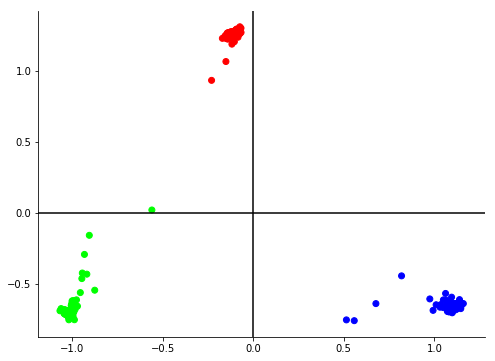

Value of beta:  0.2


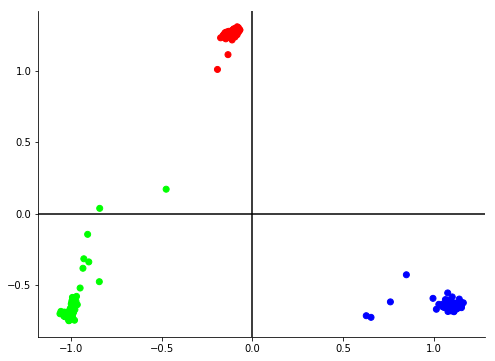

Value of beta:  0.2


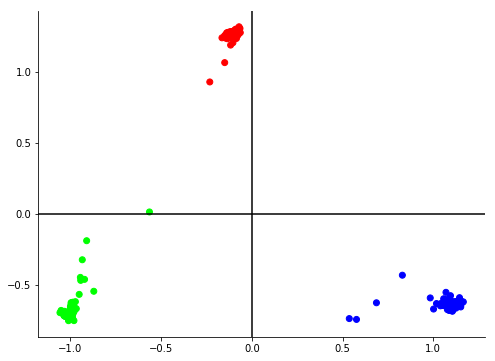

Value of beta:  0.2


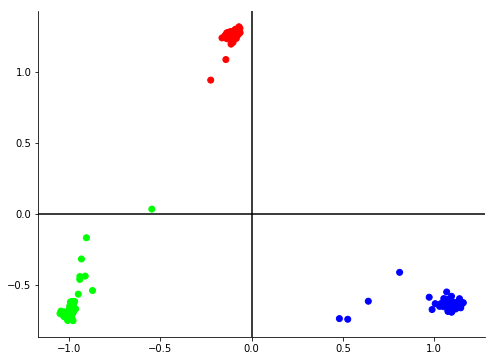

Value of beta:  0.2


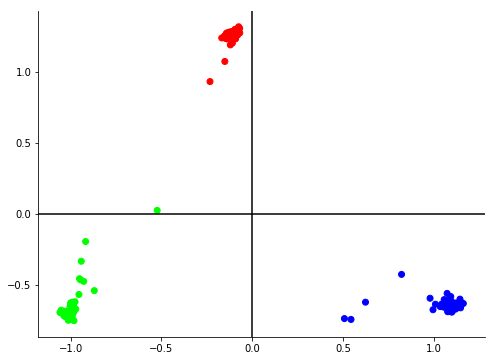

Value of beta:  0.2


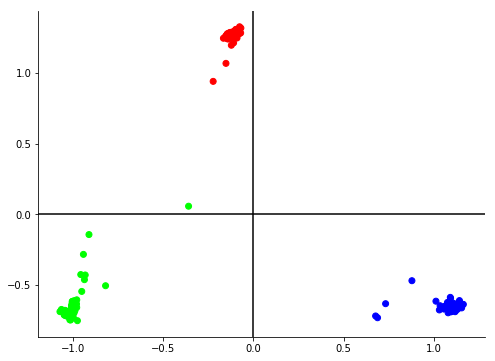

Value of beta:  0.2


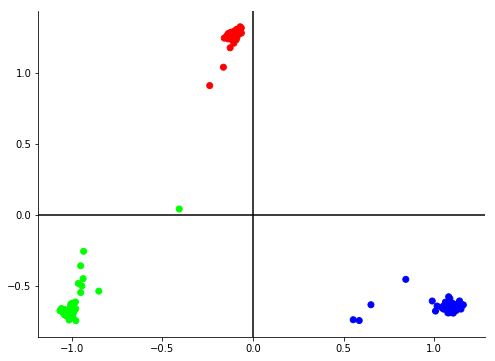

Value of beta:  0.2



KeyboardInterrupt: 

In [29]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        print('Value of beta: ', beta.numpy())
        losses = train_loop_online(model, optimizer, data_gen, iterations_per_epoch, 
                            batch_size, X_test, m_test, p_bar, beta, clip_value=clip_value, 
                            global_step=global_step, beta_update_every=1000)
        z_mean, _, _ = model(X_test, return_prob=True)
        plot_latent(z_mean, m_test)
        manager.save()

# Evaluate performance

In [50]:
samples = model.sample(X_test, n_post_samples)

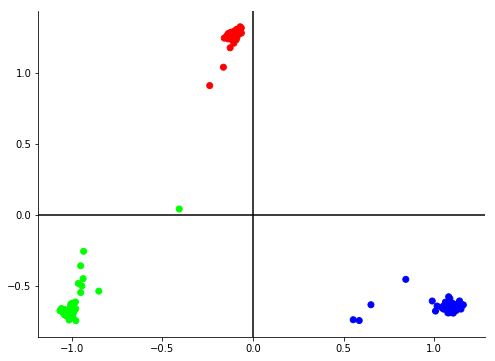

In [51]:
z_mean, z_var, m_hat = model(X_test, return_prob=True)
plot_latent(z_mean, m_test)

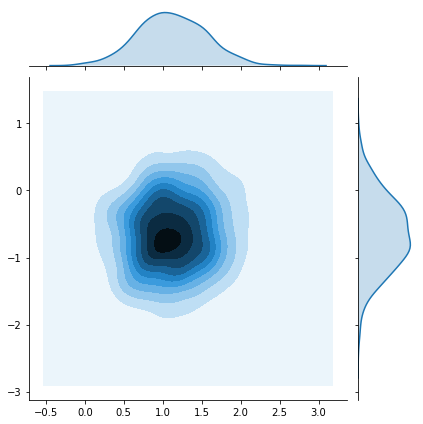

In [52]:
z1 = np.random.normal(z_mean[0, 0], tf.exp(z_var[0, 0] * 0.5), 1000)
z2 = np.random.normal(z_mean[0, 1], tf.exp(z_var[0, 1] * 0.5), 1000)
sns.jointplot(z1, z2, kind="kde")

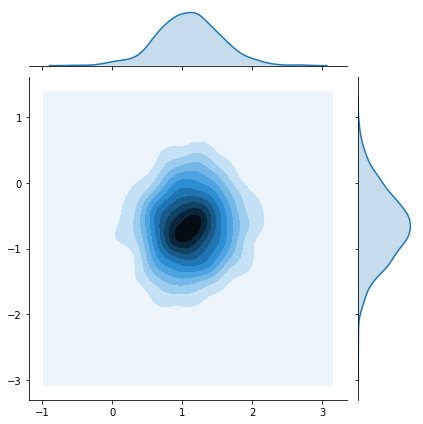

In [53]:
z1 = np.random.normal(z_mean[1, 0], tf.exp(z_var[1, 0] * 0.5), 1000)
z2 = np.random.normal(z_mean[1, 1], tf.exp(z_var[1, 1] * 0.5), 1000)
sns.jointplot(z1, z2, kind="kde")

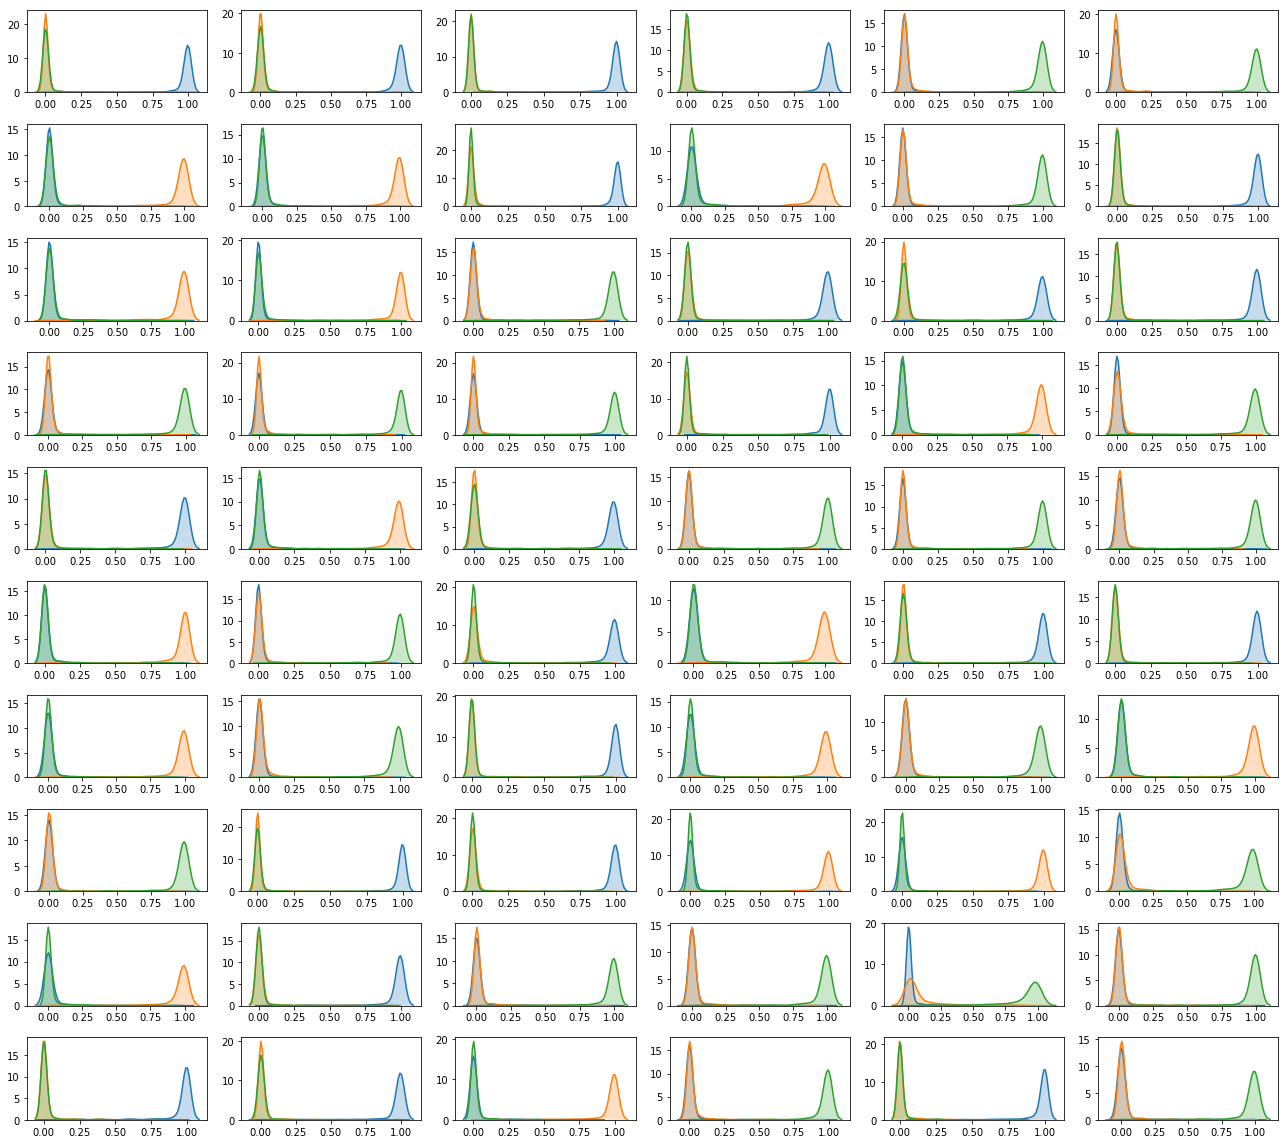

In [66]:
nrow = 10
ncol = 6
f, axarr = plt.subplots(nrow, ncol, figsize=(18, 16))
indices = np.random.permutation(n_test)[:(nrow*ncol)]
for i, ax in enumerate(axarr.flat):
    sns.distplot(samples[indices[i], :, 0], hist=False, kde_kws={'shade': True}, ax=ax)
    sns.distplot(samples[indices[i], :, 1], hist=False, kde_kws={'shade': True}, ax=ax)
    sns.distplot(samples[indices[i], :, 2], hist=False, kde_kws={'shade': True}, ax=ax)
f.tight_layout()